# PRE - PROCESSING

## Import functions

In [1]:
!pip install meteostat

In [2]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [3]:
import holidays # For working with holiday data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from datetime import datetime
from meteostat import Stations, Daily # For working with weather data
from xgboost import plot_importance


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [4]:
## Features Functions

def create_datetime_features(df):
    """
    Creates time series features from datetime index
    Adapted from: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost#Look-at-Worst-and-Best-Predicted-Days
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date'] = pd.to_datetime(df.index.date)
    return df

def get_holiday_features(df, country_code='US'):
    """
    Creates holiday features from datetime index
    """
    year_range = list(range(min(df.index.year), max(df.index.year) + 1))
    country_holidays = holidays.country_holidays(
        country_code,
        years=year_range,
        observed=False
    )
    holiday_df = pd.DataFrame(country_holidays.items())
    holiday_df.columns = ['date', 'holiday']
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    return holiday_df

def get_weather_features(df, lat, lon):
    """
    Creates weather features based on latitude and longitude
    """
    room_temperature = 20  # Weather data is in Celsius
    start = min(df.index)
    end = max(df.index)

    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(1)

    # Get daily data
    weather_data = Daily(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()
    weather_data = weather_data.dropna(axis=1)
    weather_data = weather_data.reset_index()
    weather_data['tmin_abs_diff_from_room_temperature'] = abs(weather_data['tmin'] - room_temperature)
    weather_data['tmax_abs_diff_from_room_temperature'] = abs(weather_data['tmax'] - room_temperature)
    weather_data = weather_data.rename(columns ={'time': 'date'})

    return weather_data

## Import data and feature engineering

In [5]:
main = 'https://raw.githubusercontent.com/Brunchcode/Forecasting-Energy-Consumption-Using-Machine-Learning/main/data/Timeseries/Timeseries_PJM_DOM_consumption_2006_to_2024.csv'

data_main = pd.read_csv(main,index_col=[0], parse_dates=[0])
data = create_datetime_features(data_main)
holiday_features = get_holiday_features(data)
weather_features = get_weather_features(data, 37.5407, -77.4360) # Richmond Capital of Virgina
data['datetime'] = data.index
data = data.merge(holiday_features, how='left', on='date')
data['holiday'] = data['holiday'].fillna('')
data = pd.get_dummies(data)
data = data.merge(weather_features, how='left', on='date')


remove_for_case_study = datetime(2020, 1, 1)
data_till_2019 = data.loc[data['datetime'] <= remove_for_case_study].copy()
case_study_data = data.loc[data['datetime'] > remove_for_case_study].copy()

In [6]:
data.head()

energy_consumption_mw       date  hour  dayofweek  quarter  month  year  \
0                 9250.0 2006-01-01     0          6        1      1  2006   
1                 8978.0 2006-01-01     1          6        1      1  2006   
2                 8773.0 2006-01-01     2          6        1      1  2006   
3                 8671.0 2006-01-01     3          6        1      1  2006   
4                 8664.0 2006-01-01     4          6        1      1  2006   

   dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
0          1           1          52  ...                False   
1          1           1          52  ...                False   
2          1           1          52  ...                False   
3          1           1          52  ...                False   
4          1           1          52  ...                False   

   holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
0                 False                          False   5.8  -1.1  11.7   
1                 False                          False   5.8  -1.1  11.7   
2                 False                          False   5.8  -1.1  11.7   
3                 False                          False   5.8  -1.1  11.7   
4                 False                          False   5.8  -1.1  11.7   

   prcp  wspd  tmin_abs_diff_from_room_temperature  \
0   0.0   4.0                                 21.1   
1   0.0   4.0                                 21.1   
2   0.0   4.0                                 21.1   
3   0.0   4.0                                 21.1   
4   0.0   4.0                                 21.1   

   tmax_abs_diff_from_room_temperature  
0                                  8.3  
1                                  8.3  
2                                  8.3  
3                                  8.3  
4                                  8.3  

[5 rows x 30 columns]

In [7]:
data.tail()

energy_consumption_mw       date  hour  dayofweek  quarter  month  \
162882              20498.376 2024-07-31    19          2        3      7   
162883              19814.648 2024-07-31    20          2        3      7   
162884              18910.259 2024-07-31    21          2        3      7   
162885              17645.255 2024-07-31    22          2        3      7   
162886              16421.592 2024-07-31    23          2        3      7   

        year  dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
162882  2024        213          31          31  ...                False   
162883  2024        213          31          31  ...                False   
162884  2024        213          31          31  ...                False   
162885  2024        213          31          31  ...                False   
162886  2024        213          31          31  ...                False   

        holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
162882                 False                          False  26.2  22.2  32.2   
162883                 False                          False  26.2  22.2  32.2   
162884                 False                          False  26.2  22.2  32.2   
162885                 False                          False  26.2  22.2  32.2   
162886                 False                          False  26.2  22.2  32.2   

        prcp  wspd  tmin_abs_diff_from_room_temperature  \
162882   0.3   7.9                                  2.2   
162883   0.3   7.9                                  2.2   
162884   0.3   7.9                                  2.2   
162885   0.3   7.9                                  2.2   
162886   0.3   7.9                                  2.2   

        tmax_abs_diff_from_room_temperature  
162882                                 12.2  
162883                                 12.2  
162884                                 12.2  
162885                                 12.2  
162886                                 12.2  

[5 rows x 30 columns]

In [8]:
data_till_2019.head()

energy_consumption_mw       date  hour  dayofweek  quarter  month  year  \
0                 9250.0 2006-01-01     0          6        1      1  2006   
1                 8978.0 2006-01-01     1          6        1      1  2006   
2                 8773.0 2006-01-01     2          6        1      1  2006   
3                 8671.0 2006-01-01     3          6        1      1  2006   
4                 8664.0 2006-01-01     4          6        1      1  2006   

   dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
0          1           1          52  ...                False   
1          1           1          52  ...                False   
2          1           1          52  ...                False   
3          1           1          52  ...                False   
4          1           1          52  ...                False   

   holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
0                 False                          False   5.8  -1.1  11.7   
1                 False                          False   5.8  -1.1  11.7   
2                 False                          False   5.8  -1.1  11.7   
3                 False                          False   5.8  -1.1  11.7   
4                 False                          False   5.8  -1.1  11.7   

   prcp  wspd  tmin_abs_diff_from_room_temperature  \
0   0.0   4.0                                 21.1   
1   0.0   4.0                                 21.1   
2   0.0   4.0                                 21.1   
3   0.0   4.0                                 21.1   
4   0.0   4.0                                 21.1   

   tmax_abs_diff_from_room_temperature  
0                                  8.3  
1                                  8.3  
2                                  8.3  
3                                  8.3  
4                                  8.3  

[5 rows x 30 columns]

In [9]:
data_till_2019.tail()

energy_consumption_mw       date  hour  dayofweek  quarter  month  \
122708              11442.870 2019-12-31    20          1        4     12   
122709              11166.770 2019-12-31    21          1        4     12   
122710              10838.550 2019-12-31    22          1        4     12   
122711              10592.674 2019-12-31    23          1        4     12   
122712              10364.707 2020-01-01     0          2        1      1   

        year  dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
122708  2019        365          31           1  ...                False   
122709  2019        365          31           1  ...                False   
122710  2019        365          31           1  ...                False   
122711  2019        365          31           1  ...                False   
122712  2020          1           1           1  ...                False   

        holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
122708                 False                          False  10.9   5.0  13.9   
122709                 False                          False  10.9   5.0  13.9   
122710                 False                          False  10.9   5.0  13.9   
122711                 False                          False  10.9   5.0  13.9   
122712                 False                          False   7.1   1.7  12.2   

        prcp  wspd  tmin_abs_diff_from_room_temperature  \
122708   0.0  11.9                                 15.0   
122709   0.0  11.9                                 15.0   
122710   0.0  11.9                                 15.0   
122711   0.0  11.9                                 15.0   
122712   0.0  13.7                                 18.3   

        tmax_abs_diff_from_room_temperature  
122708                                  6.1  
122709                                  6.1  
122710                                  6.1  
122711                                  6.1  
122712                                  7.8  

[5 rows x 30 columns]

In [10]:
case_study_data.head()

energy_consumption_mw       date  hour  dayofweek  quarter  month  \
122713              10291.858 2020-01-01     1          2        1      1   
122714              10252.082 2020-01-01     2          2        1      1   
122715              10303.804 2020-01-01     3          2        1      1   
122716              10588.920 2020-01-01     4          2        1      1   
122717              10980.540 2020-01-01     5          2        1      1   

        year  dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
122713  2020          1           1           1  ...                False   
122714  2020          1           1           1  ...                False   
122715  2020          1           1           1  ...                False   
122716  2020          1           1           1  ...                False   
122717  2020          1           1           1  ...                False   

        holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
122713                 False                          False   7.1   1.7  12.2   
122714                 False                          False   7.1   1.7  12.2   
122715                 False                          False   7.1   1.7  12.2   
122716                 False                          False   7.1   1.7  12.2   
122717                 False                          False   7.1   1.7  12.2   

        prcp  wspd  tmin_abs_diff_from_room_temperature  \
122713   0.0  13.7                                 18.3   
122714   0.0  13.7                                 18.3   
122715   0.0  13.7                                 18.3   
122716   0.0  13.7                                 18.3   
122717   0.0  13.7                                 18.3   

        tmax_abs_diff_from_room_temperature  
122713                                  7.8  
122714                                  7.8  
122715                                  7.8  
122716                                  7.8  
122717                                  7.8  

[5 rows x 30 columns]

In [11]:
case_study_data.tail()

energy_consumption_mw       date  hour  dayofweek  quarter  month  \
162882              20498.376 2024-07-31    19          2        3      7   
162883              19814.648 2024-07-31    20          2        3      7   
162884              18910.259 2024-07-31    21          2        3      7   
162885              17645.255 2024-07-31    22          2        3      7   
162886              16421.592 2024-07-31    23          2        3      7   

        year  dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
162882  2024        213          31          31  ...                False   
162883  2024        213          31          31  ...                False   
162884  2024        213          31          31  ...                False   
162885  2024        213          31          31  ...                False   
162886  2024        213          31          31  ...                False   

        holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
162882                 False                          False  26.2  22.2  32.2   
162883                 False                          False  26.2  22.2  32.2   
162884                 False                          False  26.2  22.2  32.2   
162885                 False                          False  26.2  22.2  32.2   
162886                 False                          False  26.2  22.2  32.2   

        prcp  wspd  tmin_abs_diff_from_room_temperature  \
162882   0.3   7.9                                  2.2   
162883   0.3   7.9                                  2.2   
162884   0.3   7.9                                  2.2   
162885   0.3   7.9                                  2.2   
162886   0.3   7.9                                  2.2   

        tmax_abs_diff_from_room_temperature  
162882                                 12.2  
162883                                 12.2  
162884                                 12.2  
162885                                 12.2  
162886                                 12.2  

[5 rows x 30 columns]

# DEEP LEARNING MLPs

## First model

Epoch 1/150


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0319 - val_loss: 0.0146
Epoch 2/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0113 - val_loss: 0.0095
Epoch 3/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 4/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 5/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 6/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 7/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 8/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 11/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 12/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

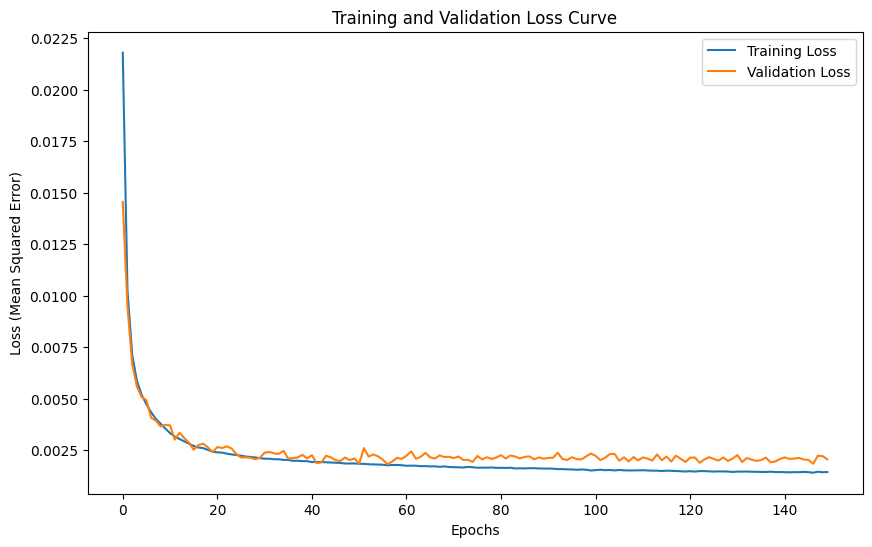

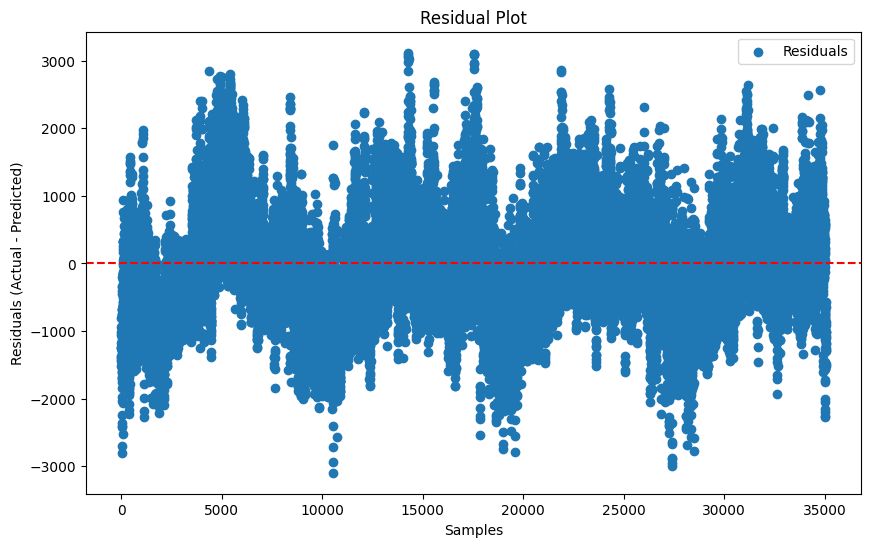

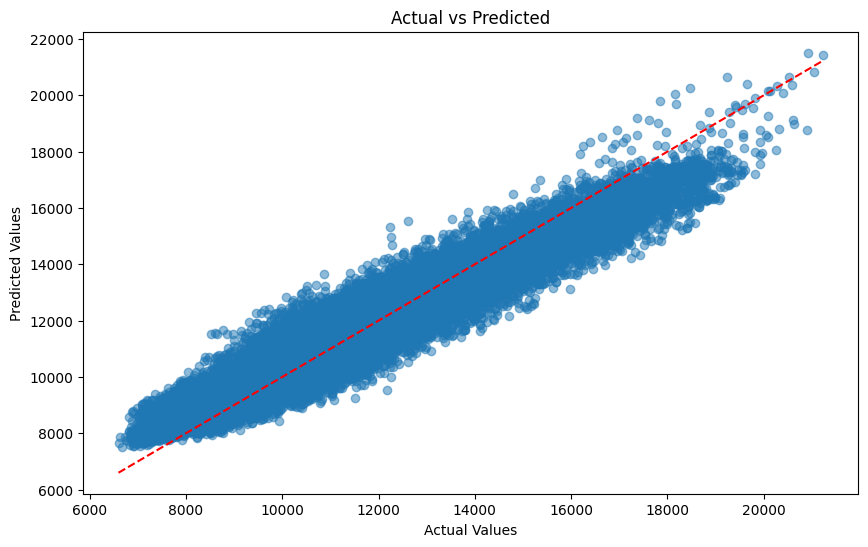

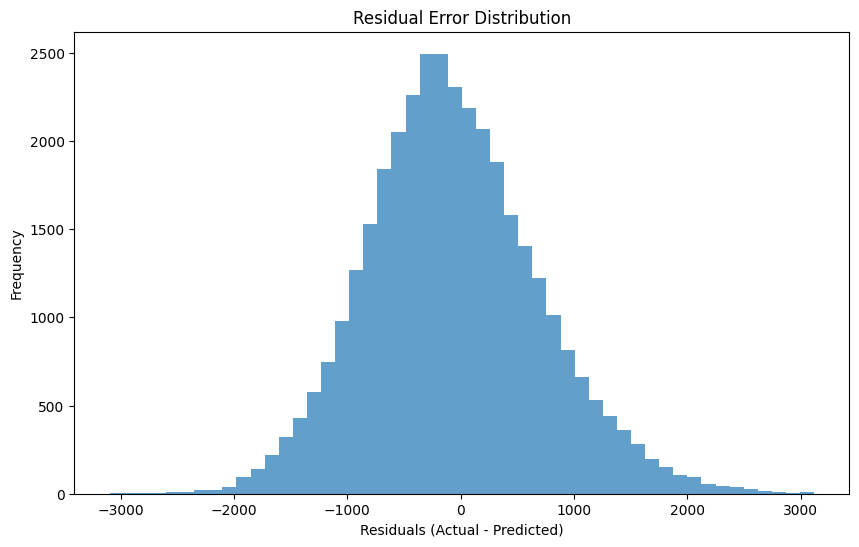

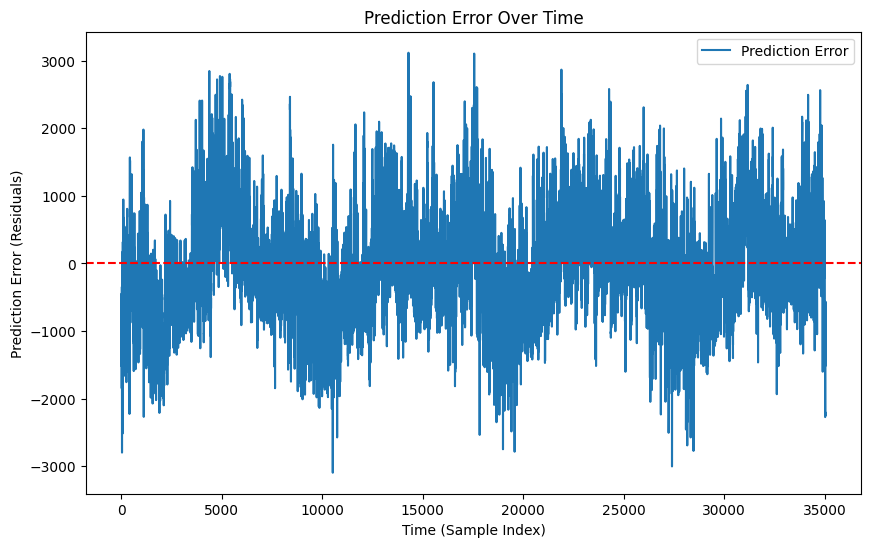

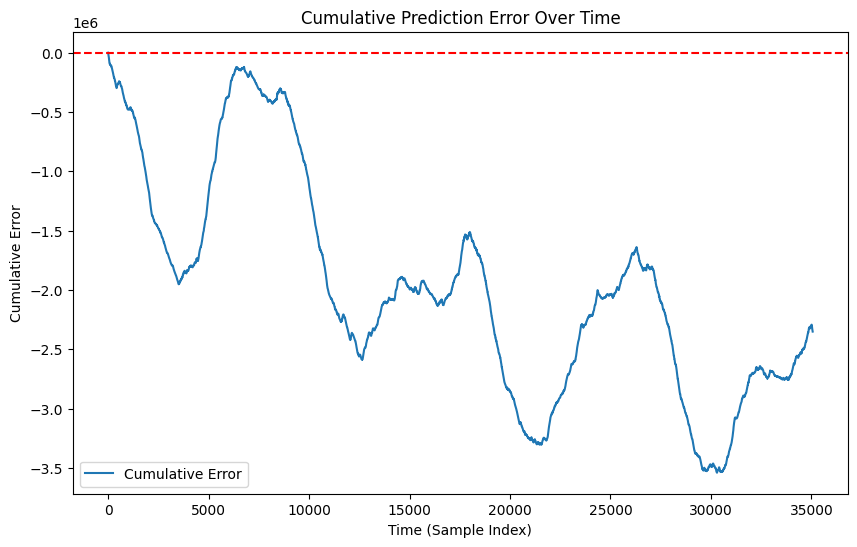

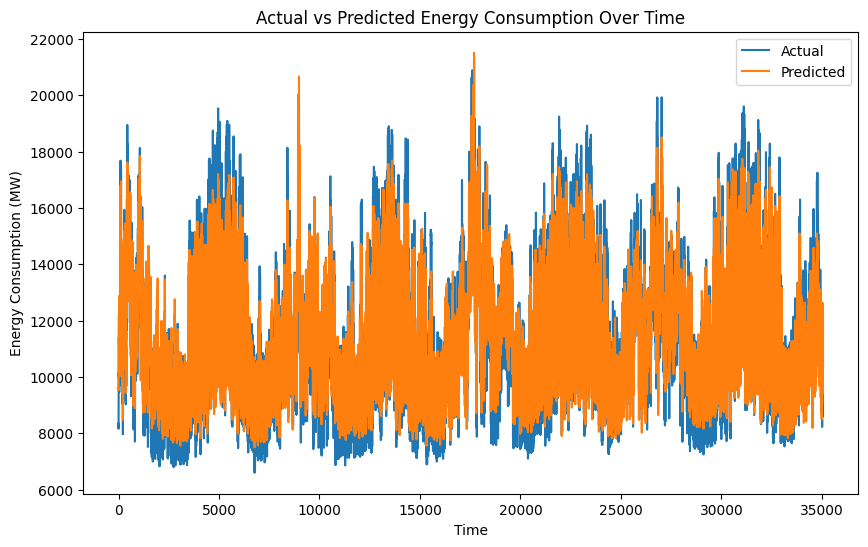

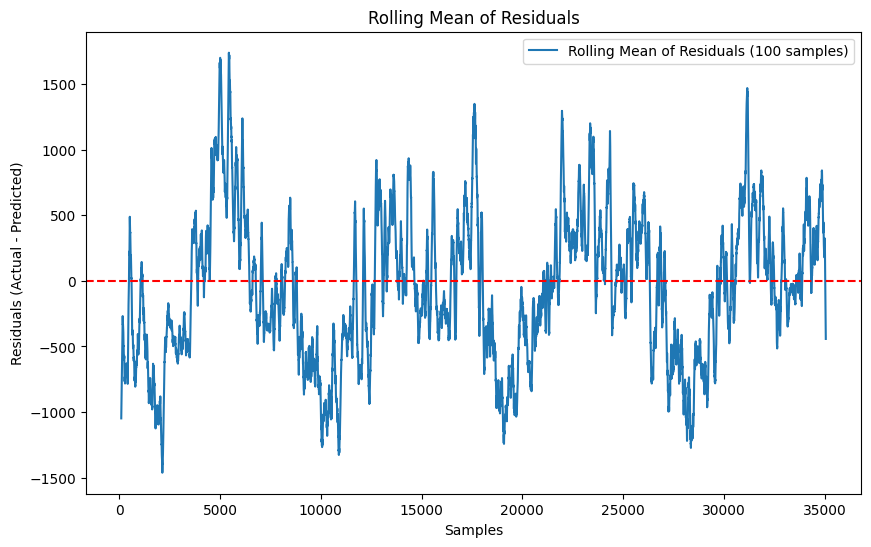

<Figure size 1000x600 with 0 Axes>

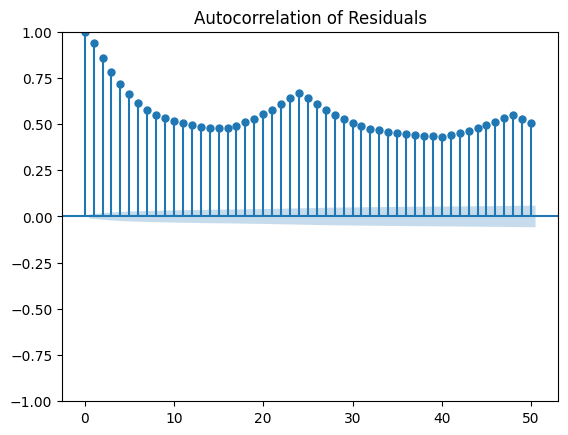

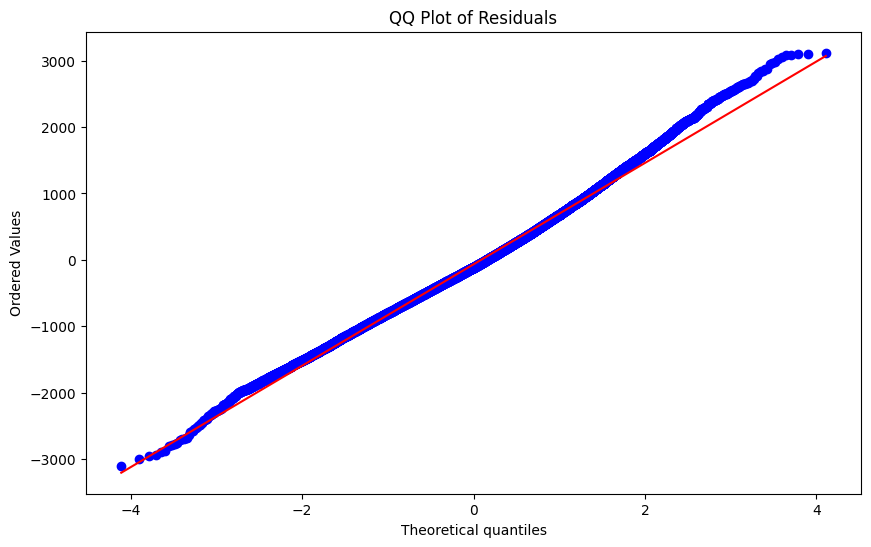

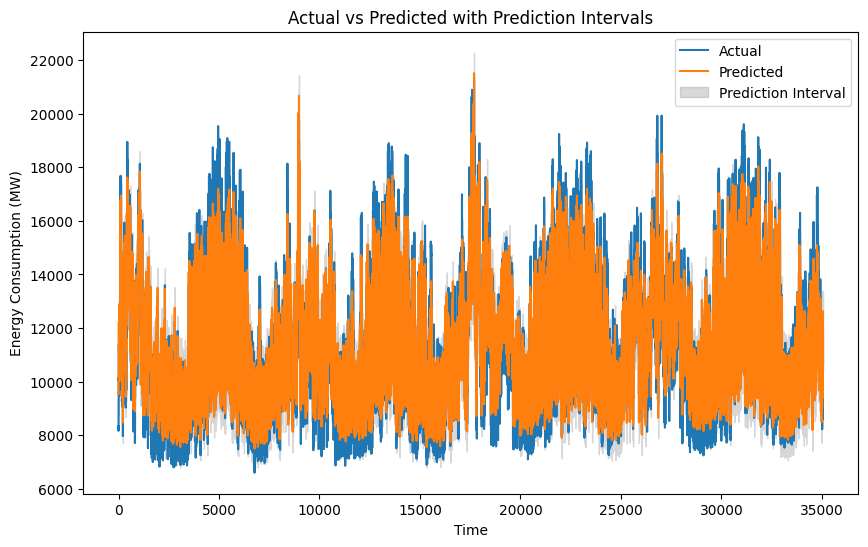

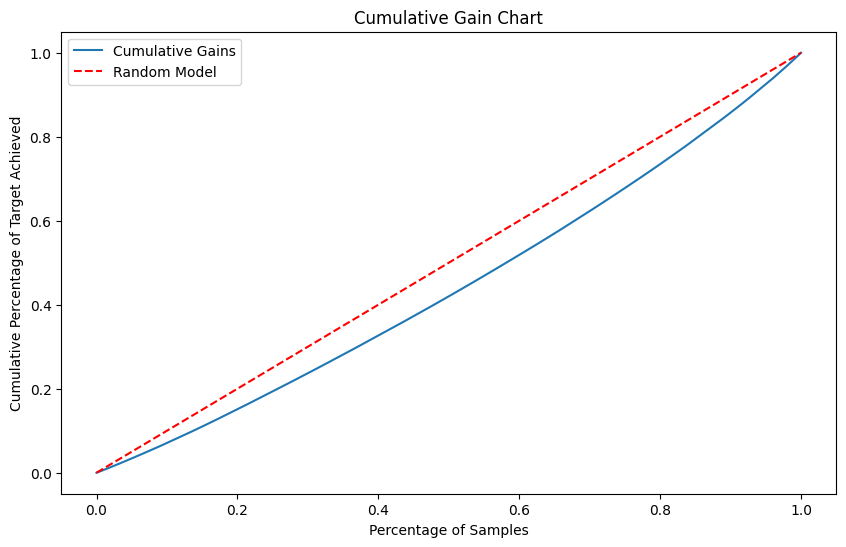

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
import statsmodels.api as sm
import scipy.stats as stats

# Load your dataset (ensure 'datetime' and 'energy_consumption_mw' columns exist)
# Example: data_till_2019 = pd.read_csv('your_data.csv')

# Step 1: Data Preparation
split_date = '2016-01-01'
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Step 2: Build the MLP Model
def build_mlp_model(input_shape):
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for regression task

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Step 3: Train the Model
input_shape = X_train_scaled.shape[1]
mlp_model = build_mlp_model(input_shape)
history = mlp_model.fit(X_train_scaled, y_train_scaled, epochs=150, batch_size=1000, validation_data=(X_test_scaled, y_test_scaled), verbose=1)

# Step 4: Make Predictions
train_predictions = mlp_model.predict(X_train_scaled)
test_predictions = mlp_model.predict(X_test_scaled)

# Inverse transform predictions and true values
train_predictions_inv = scaler_y.inverse_transform(train_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Step 5: Evaluate the Model
rmse = mean_squared_error(y_test_inv, test_predictions_inv, squared=False)
mae = mean_absolute_error(y_test_inv, test_predictions_inv)
mape = mean_absolute_percentage_error(y_test_inv, test_predictions_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Step 6: Plotting the Results

# 6.1 Loss Curve
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

# 6.2 Residual Plot
residuals = y_test_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(range(len(residuals)), residuals, label='Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Samples')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# 6.3 Actual vs Predicted Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(y_test_inv, test_predictions_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')  # Perfect fit line
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# 6.4 Error Distribution (Histogram)
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Error Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# 6.5 Prediction Error Over Time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Prediction Error')
plt.title('Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Prediction Error (Residuals)')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 6.6 Cumulative Prediction Error
cumulative_error = np.cumsum(residuals)
plt.figure(figsize=(10,6))
plt.plot(cumulative_error, label='Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Cumulative Error')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 6.7 Actual vs Predicted Over Time
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

# Step 7: Additional Plots

# 7.1 Rolling Mean of Residuals
rolling_window = 100  # Adjust this window size
rolling_mean_residual = pd.Series(residuals.flatten()).rolling(window=rolling_window).mean()
plt.figure(figsize=(10,6))
plt.plot(rolling_mean_residual, label=f'Rolling Mean of Residuals ({rolling_window} samples)')
plt.axhline(0, color='r', linestyle='--')
plt.title('Rolling Mean of Residuals')
plt.xlabel('Samples')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# 7.2 Autocorrelation of Residuals
plt.figure(figsize=(10,6))
sm.graphics.tsa.plot_acf(residuals.flatten(), lags=50)
plt.title('Autocorrelation of Residuals')
plt.show()

# 7.3 QQ Plot of Residuals
plt.figure(figsize=(10,6))
stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()

# 7.4 Prediction Interval
residual_std = np.std(residuals)
upper_bound = test_predictions_inv + residual_std
lower_bound = test_predictions_inv - residual_std
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted')
plt.fill_between(range(len(y_test_inv)), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.3, label='Prediction Interval')
plt.title('Actual vs Predicted with Prediction Intervals')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

# 7.5 Cumulative Gain Chart
def plot_cumulative_gain(y_true, y_pred):
    sorted_indices = np.argsort(y_pred.flatten())
    sorted_true = np.array(y_true).flatten()[sorted_indices]
    gains = np.cumsum(sorted_true) / np.sum(sorted_true)
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(gains)) / len(gains), gains, label='Cumulative Gains')
    plt.plot([0, 1], [0, 1], '--', color='red', label='Random Model')
    plt.title('Cumulative Gain Chart')
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Cumulative Percentage of Target Achieved')
    plt.legend()
    plt.show()

plot_cumulative_gain(y_test_inv, test_predictions_inv)


## MLP Model

Epoch 1/150


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0438 - val_loss: 0.0159
Epoch 2/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0130 - val_loss: 0.0110
Epoch 3/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 4/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 5/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 6/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 7/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 8/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 9/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 10/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 11/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 12/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - va

RMSE: 854.9416059090487
MAE: 673.3106689010853
MAPE: 0.058232946471669614
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Loaded Model RMSE: 854.9416059090487
Loaded Model MAE: 673.3106689010853
Loaded Model MAPE: 0.058232946471669614


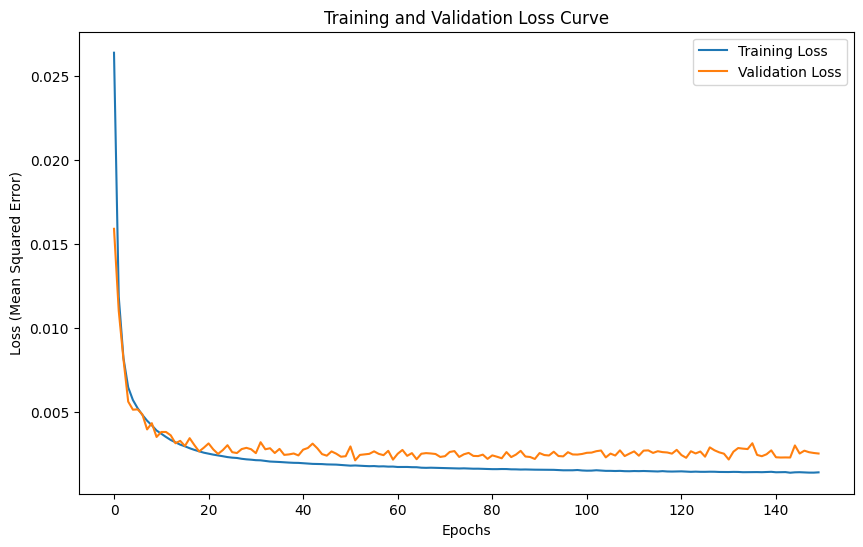

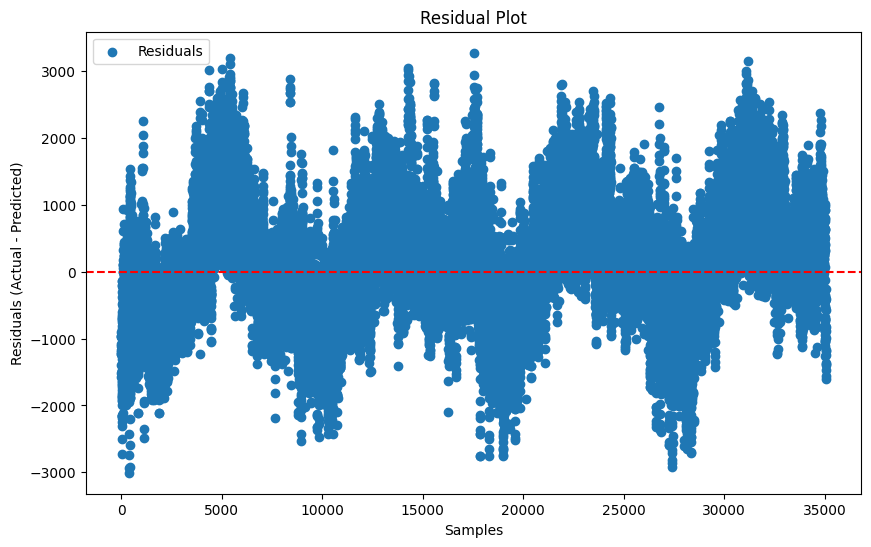

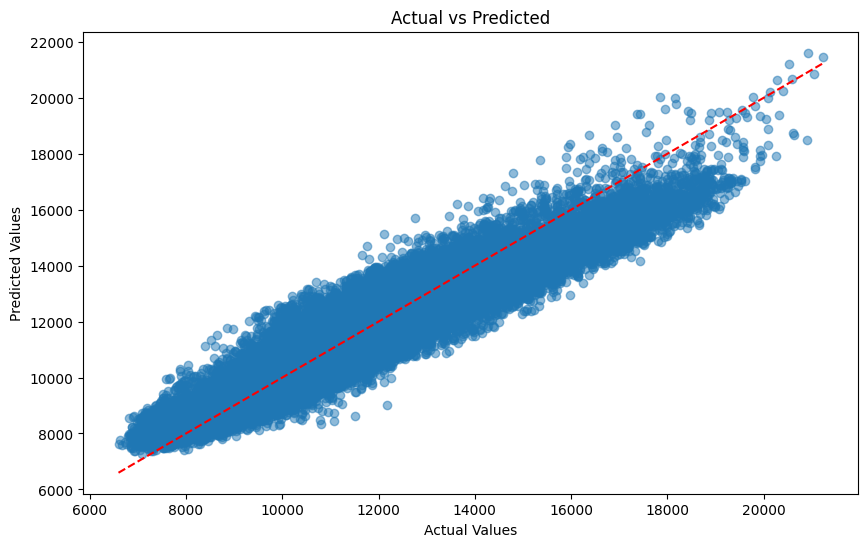

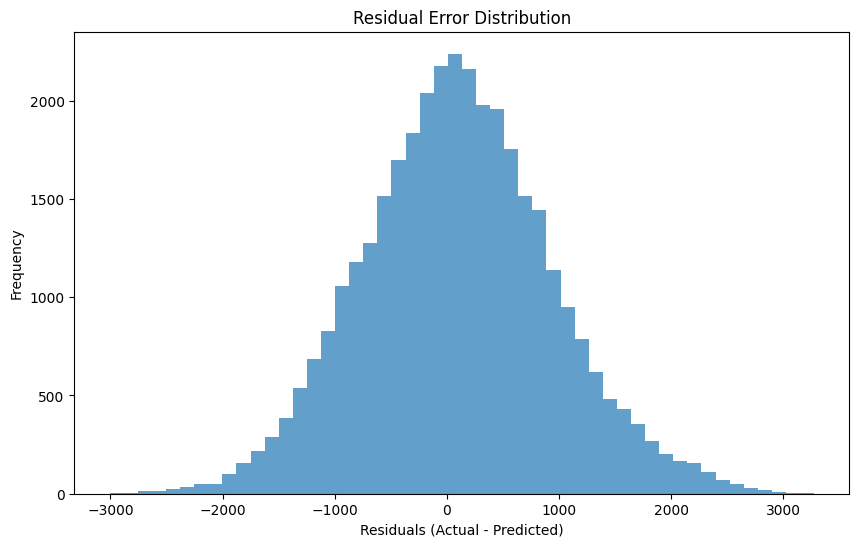

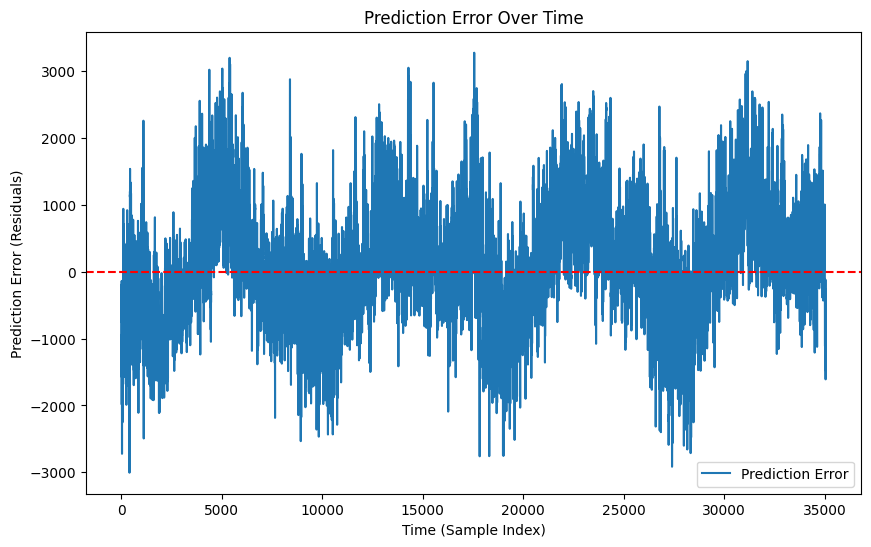

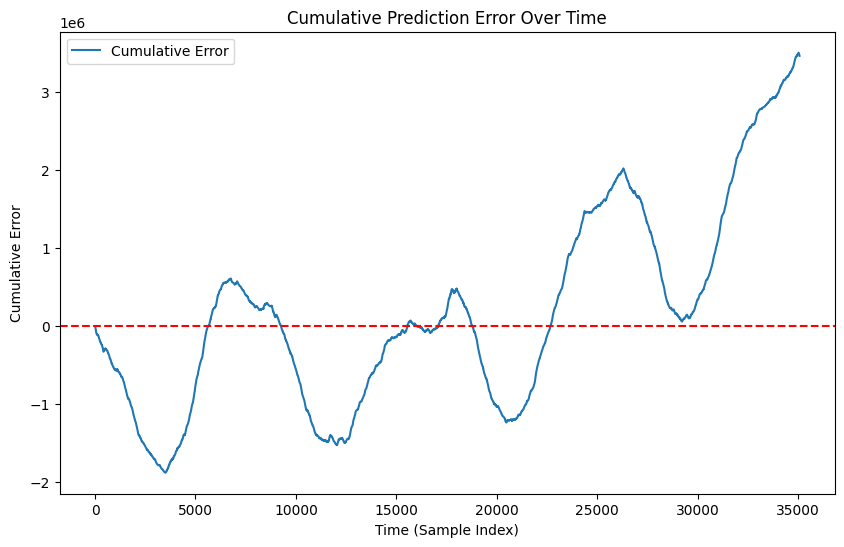

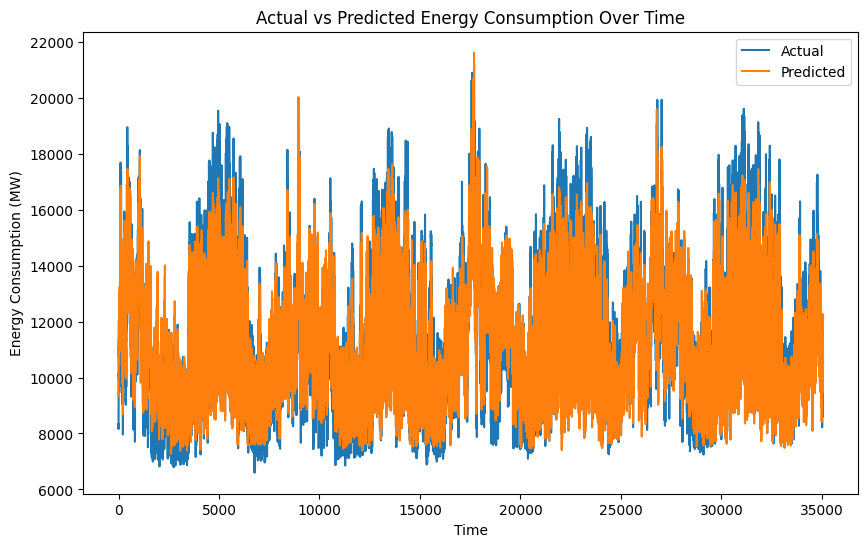

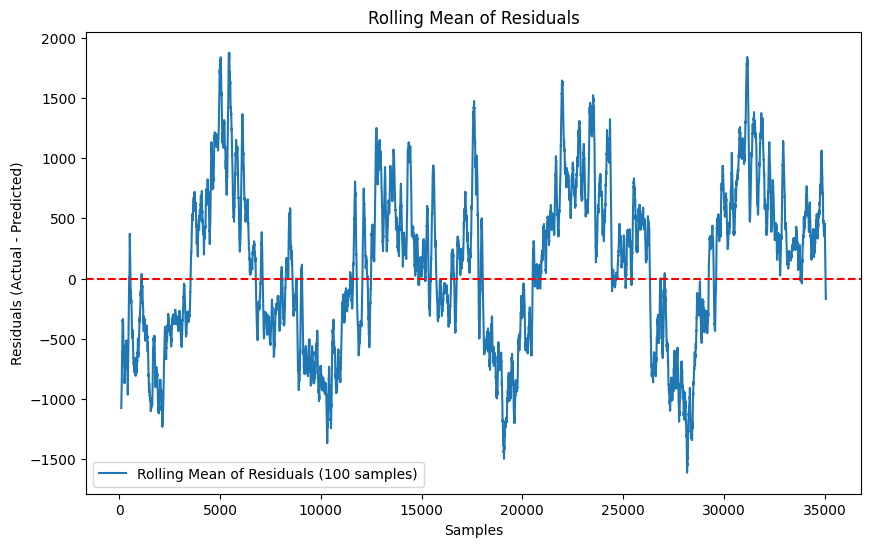

<Figure size 1000x600 with 0 Axes>

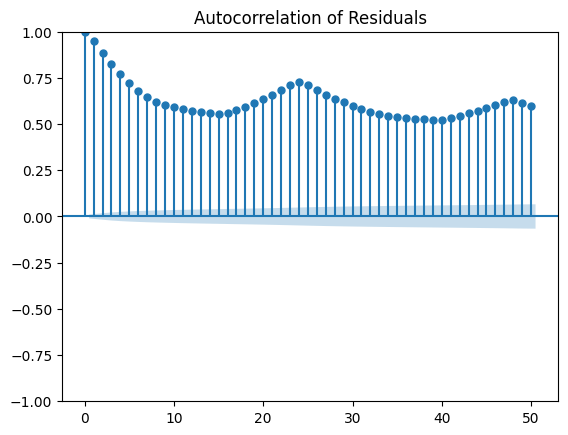

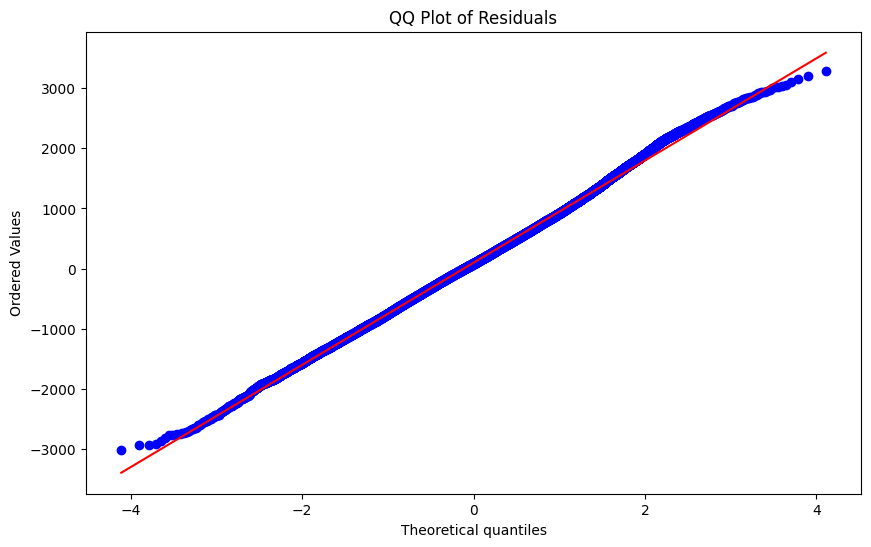

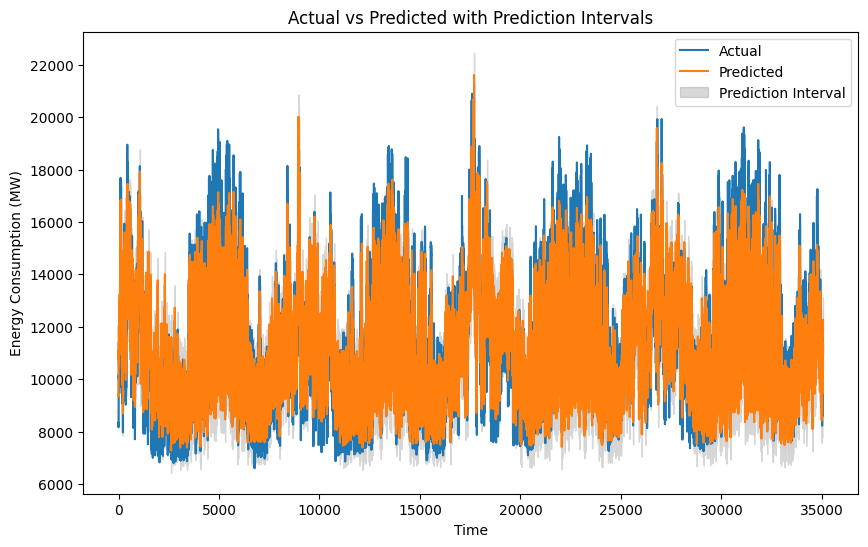

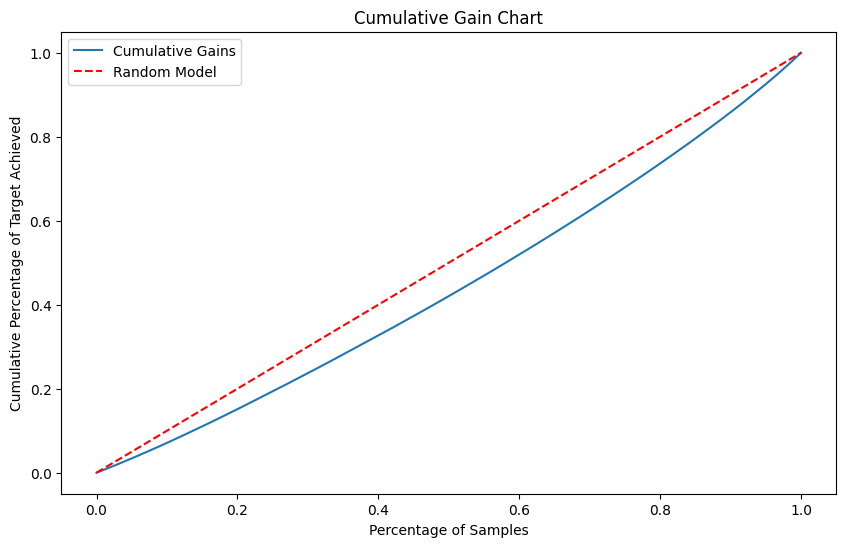

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
import statsmodels.api as sm
import scipy.stats as stats

# Load your dataset (ensure 'datetime' and 'energy_consumption_mw' columns exist)
# Example: data_till_2019 = pd.read_csv('your_data.csv')

# Step 1: Data Preparation
split_date = '2016-01-01'
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Step 2: Build the MLP Model
def build_mlp_model(input_shape):
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for regression task

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Step 3: Train the Model
input_shape = X_train_scaled.shape[1]
mlp_model = build_mlp_model(input_shape)
history = mlp_model.fit(X_train_scaled, y_train_scaled, epochs=150, batch_size=1000, validation_data=(X_test_scaled, y_test_scaled), verbose=1)

# Step 4: Make Predictions
train_predictions = mlp_model.predict(X_train_scaled)
test_predictions = mlp_model.predict(X_test_scaled)

# Inverse transform predictions and true values
train_predictions_inv = scaler_y.inverse_transform(train_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Step 5: Evaluate the Model
rmse = mean_squared_error(y_test_inv, test_predictions_inv, squared=False)
mae = mean_absolute_error(y_test_inv, test_predictions_inv)
mape = mean_absolute_percentage_error(y_test_inv, test_predictions_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")


mlp_model.save('mlp_energy_model1.h5')  # Save the model
# Step 6: Load the Model and Re-evaluate
loaded_model = load_model('mlp_energy_model1.h5')

# Make predictions using the loaded model
test_predictions_loaded = loaded_model.predict(X_test_scaled)

# Inverse transform predictions and true values
test_predictions_loaded_inv = scaler_y.inverse_transform(test_predictions_loaded)

# Evaluate the loaded model
rmse_loaded = mean_squared_error(y_test_inv, test_predictions_loaded_inv, squared=False)
mae_loaded = mean_absolute_error(y_test_inv, test_predictions_loaded_inv)
mape_loaded = mean_absolute_percentage_error(y_test_inv, test_predictions_loaded_inv)

print(f"Loaded Model RMSE: {rmse_loaded}")
print(f"Loaded Model MAE: {mae_loaded}")
print(f"Loaded Model MAPE: {mape_loaded}")

# Step 6: Plotting the Results

# 6.1 Loss Curve
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

# 6.2 Residual Plot
residuals = y_test_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(range(len(residuals)), residuals, label='Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Samples')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# 6.3 Actual vs Predicted Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(y_test_inv, test_predictions_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')  # Perfect fit line
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# 6.4 Error Distribution (Histogram)
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Error Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# 6.5 Prediction Error Over Time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Prediction Error')
plt.title('Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Prediction Error (Residuals)')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 6.6 Cumulative Prediction Error
cumulative_error = np.cumsum(residuals)
plt.figure(figsize=(10,6))
plt.plot(cumulative_error, label='Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Cumulative Error')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 6.7 Actual vs Predicted Over Time
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

# Step 7: Additional Plots

# 7.1 Rolling Mean of Residuals
rolling_window = 100  # Adjust this window size
rolling_mean_residual = pd.Series(residuals.flatten()).rolling(window=rolling_window).mean()
plt.figure(figsize=(10,6))
plt.plot(rolling_mean_residual, label=f'Rolling Mean of Residuals ({rolling_window} samples)')
plt.axhline(0, color='r', linestyle='--')
plt.title('Rolling Mean of Residuals')
plt.xlabel('Samples')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# 7.2 Autocorrelation of Residuals
plt.figure(figsize=(10,6))
sm.graphics.tsa.plot_acf(residuals.flatten(), lags=50)
plt.title('Autocorrelation of Residuals')
plt.show()

# 7.3 QQ Plot of Residuals
plt.figure(figsize=(10,6))
stats.probplot(residuals.flatten(), dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()

# 7.4 Prediction Interval
residual_std = np.std(residuals)
upper_bound = test_predictions_inv + residual_std
lower_bound = test_predictions_inv - residual_std
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted')
plt.fill_between(range(len(y_test_inv)), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.3, label='Prediction Interval')
plt.title('Actual vs Predicted with Prediction Intervals')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

# 7.5 Cumulative Gain Chart
def plot_cumulative_gain(y_true, y_pred):
    sorted_indices = np.argsort(y_pred.flatten())
    sorted_true = np.array(y_true).flatten()[sorted_indices]
    gains = np.cumsum(sorted_true) / np.sum(sorted_true)
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(gains)) / len(gains), gains, label='Cumulative Gains')
    plt.plot([0, 1], [0, 1], '--', color='red', label='Random Model')
    plt.title('Cumulative Gain Chart')
    plt.xlabel('Percentage of Samples')
    plt.ylabel('Cumulative Percentage of Target Achieved')
    plt.legend()
    plt.show()

plot_cumulative_gain(y_test_inv, test_predictions_inv)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import statsmodels.api as sm
import scipy.stats as stats

# Load your dataset (assuming 'data_till_2019' is already loaded)
split_date = '2016-01-01'
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Step 2: Build the MLP Model
def build_mlp_model(input_shape):
    model = Sequential()
    model.add(Dense(units=128, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for regression task

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Step 3: Train the Model
input_shape = X_train_scaled.shape[1]
mlp_model = build_mlp_model(input_shape)
history = mlp_model.fit(X_train_scaled, y_train_scaled, epochs=150, batch_size=365, validation_data=(X_test_scaled, y_test_scaled), verbose=1)

# Step 4: Evaluate the Model Before Saving
train_predictions = mlp_model.predict(X_train_scaled)
test_predictions = mlp_model.predict(X_test_scaled)

# Inverse transform predictions and true values
train_predictions_inv = scaler_y.inverse_transform(train_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Evaluate the Model
rmse = mean_squared_error(y_test_inv, test_predictions_inv, squared=False)
mae = mean_absolute_error(y_test_inv, test_predictions_inv)
mape = mean_absolute_percentage_error(y_test_inv, test_predictions_inv)

print(f"Initial RMSE: {rmse}")
print(f"Initial MAE: {mae}")
print(f"Initial MAPE: {mape}")

# Step 5: Save the Model
mlp_model.save('mlp_energy_model2.h5')  # Save the model

# Step 6: Load the Model and Re-evaluate
loaded_model = load_model('mlp_energy_model2.h5')

# Make predictions using the loaded model
test_predictions_loaded = loaded_model.predict(X_test_scaled)

# Inverse transform predictions and true values
test_predictions_loaded_inv = scaler_y.inverse_transform(test_predictions_loaded)

# Evaluate the loaded model
rmse_loaded = mean_squared_error(y_test_inv, test_predictions_loaded_inv, squared=False)
mae_loaded = mean_absolute_error(y_test_inv, test_predictions_loaded_inv)
mape_loaded = mean_absolute_percentage_error(y_test_inv, test_predictions_loaded_inv)

print(f"Loaded Model RMSE: {rmse_loaded}")
print(f"Loaded Model MAE: {mae_loaded}")
print(f"Loaded Model MAPE: {mape_loaded}")




Epoch 1/150


241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0294 - val_loss: 0.0094
Epoch 2/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0083 - val_loss: 0.0057
Epoch 3/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 4/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 5/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 7/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 8/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 9/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 10/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 11/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 12/150
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Initial RMSE: 872.7383577499498
Initial MAE: 698.7434989829981
Initial MAPE: 0.06128180671818218
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Loaded Model RMSE: 872.7383577499498
Loaded Model MAE: 698.7434989829981
Loaded Model MAPE: 0.06128180671818218


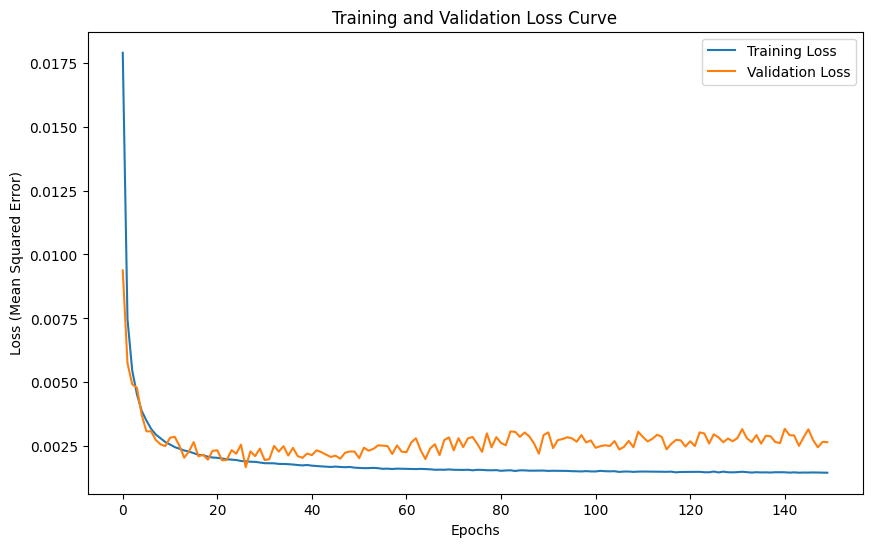

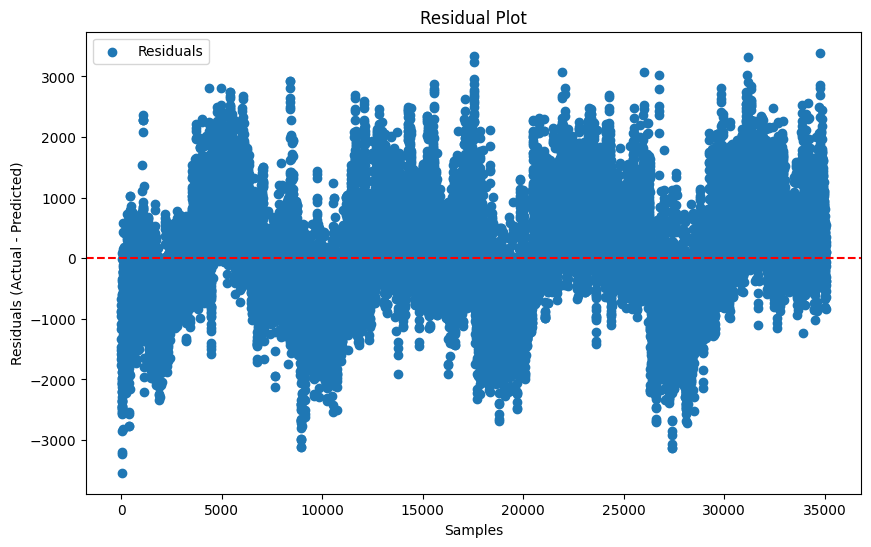

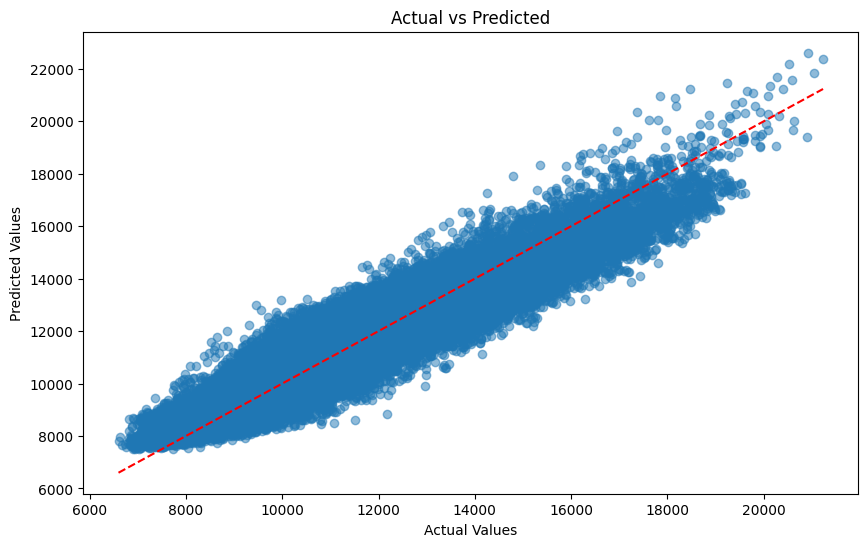

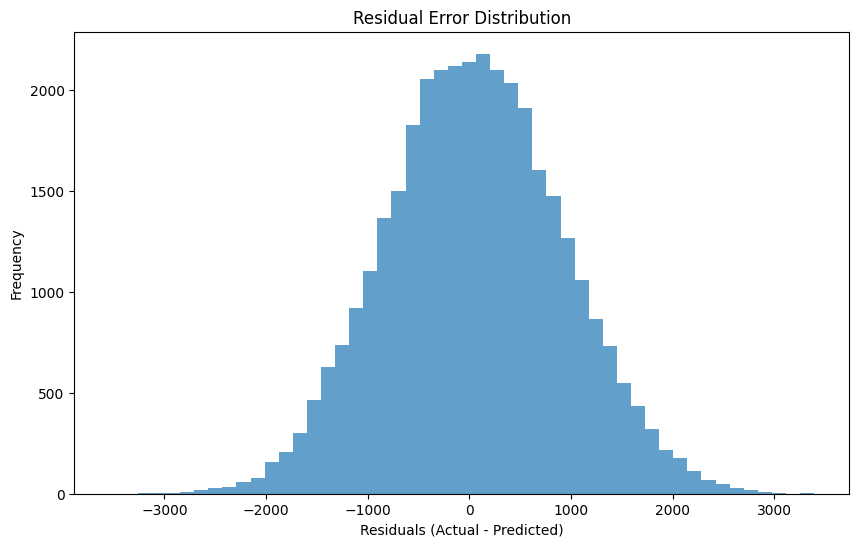

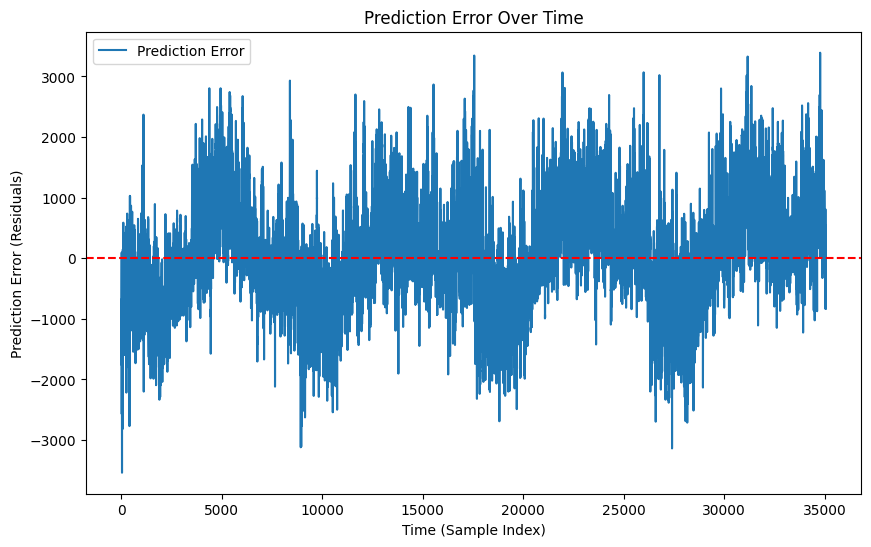

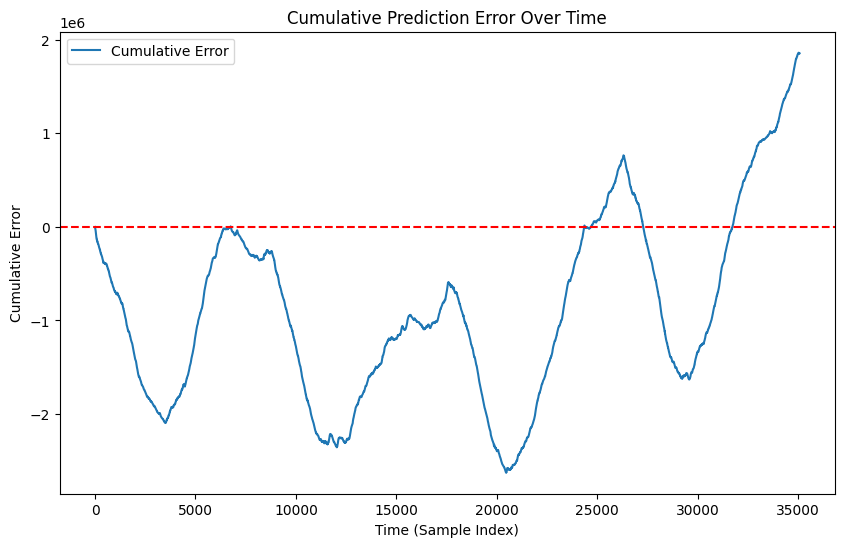

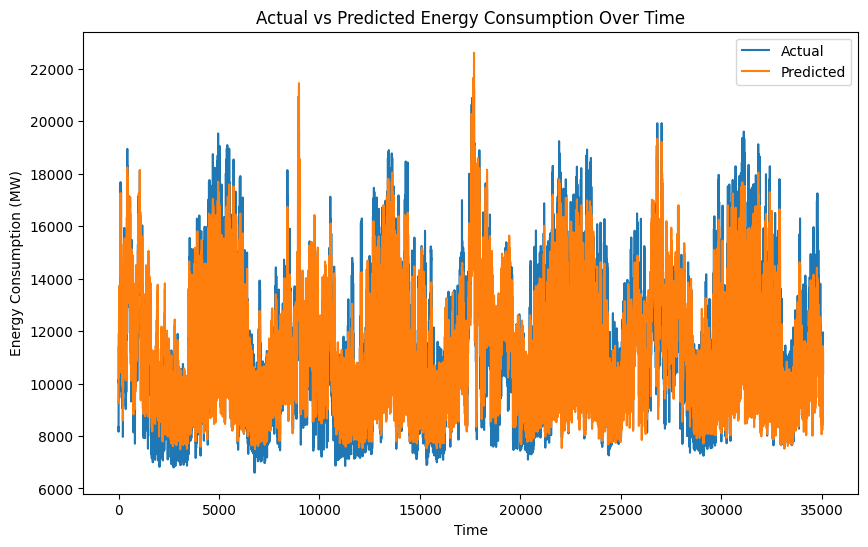

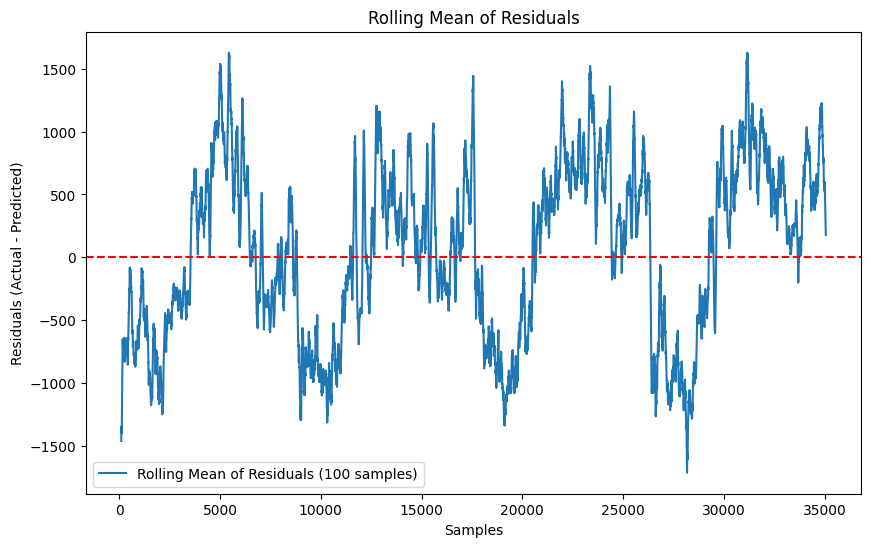

<Figure size 1000x600 with 0 Axes>

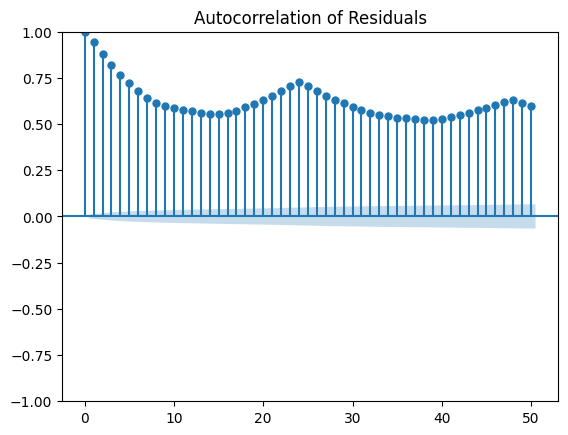

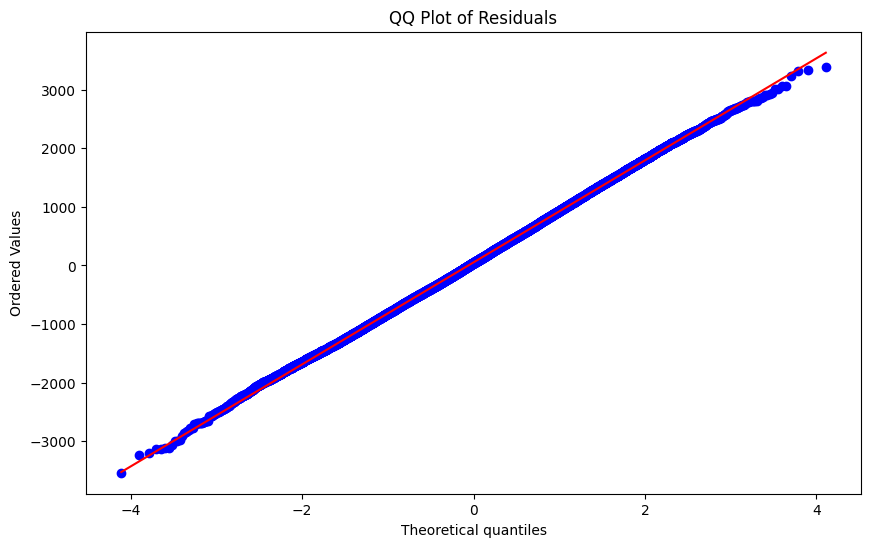

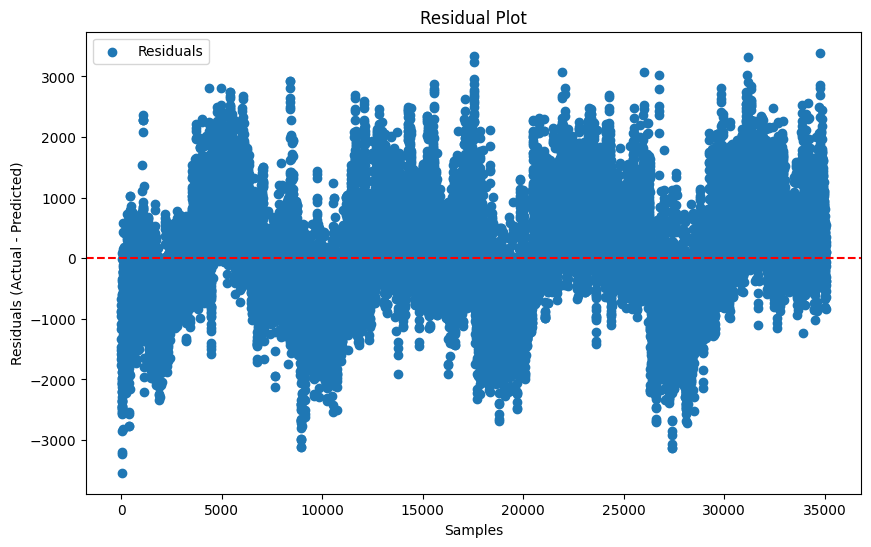

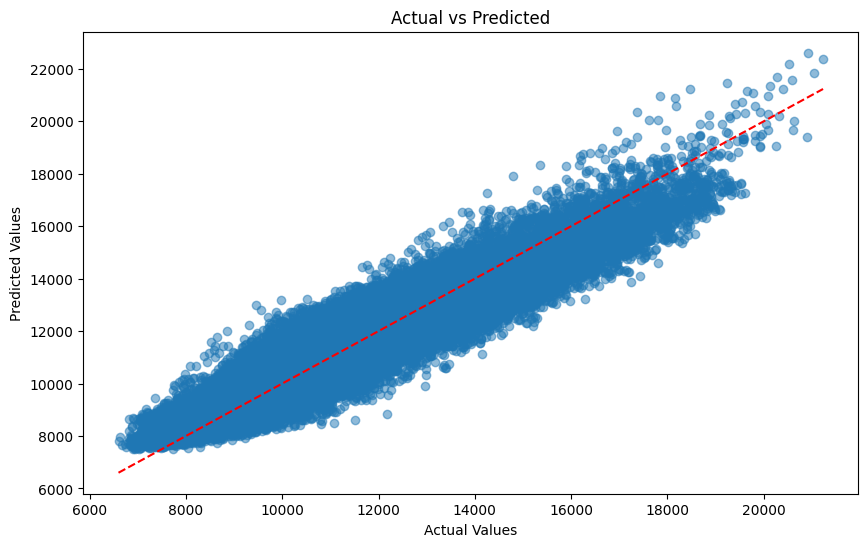

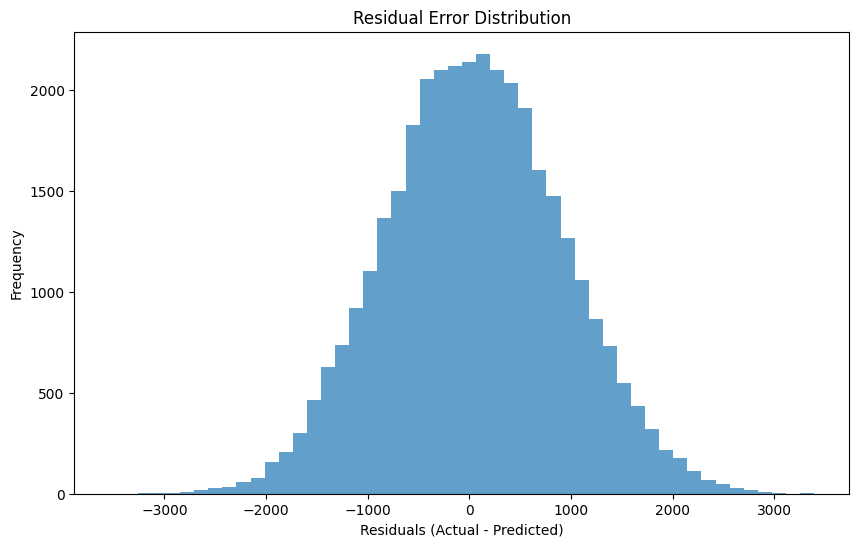

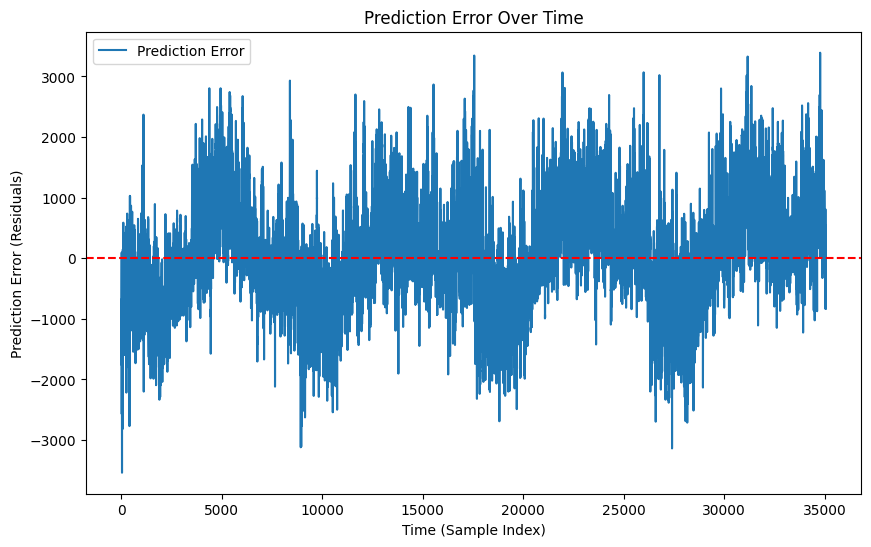

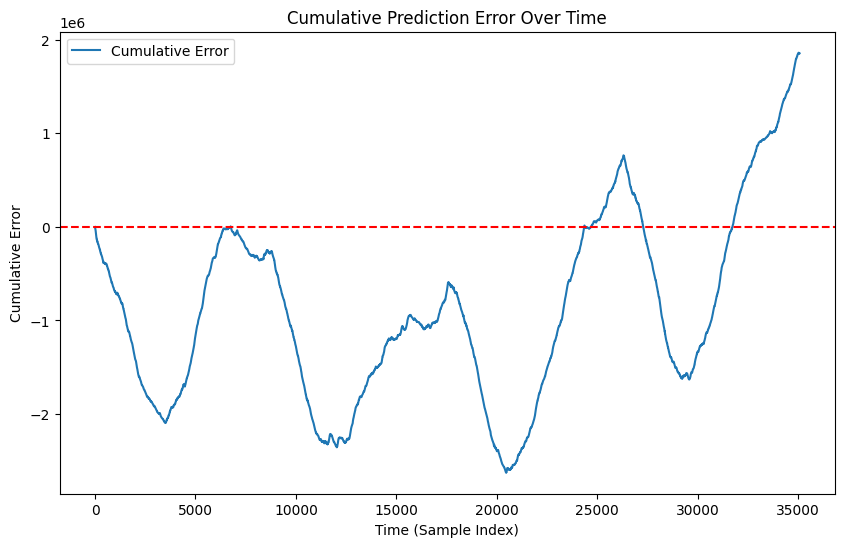

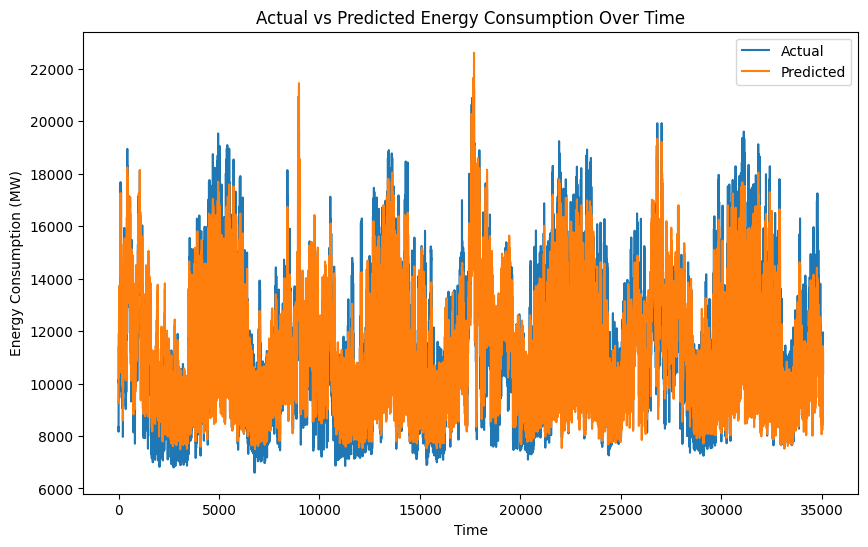

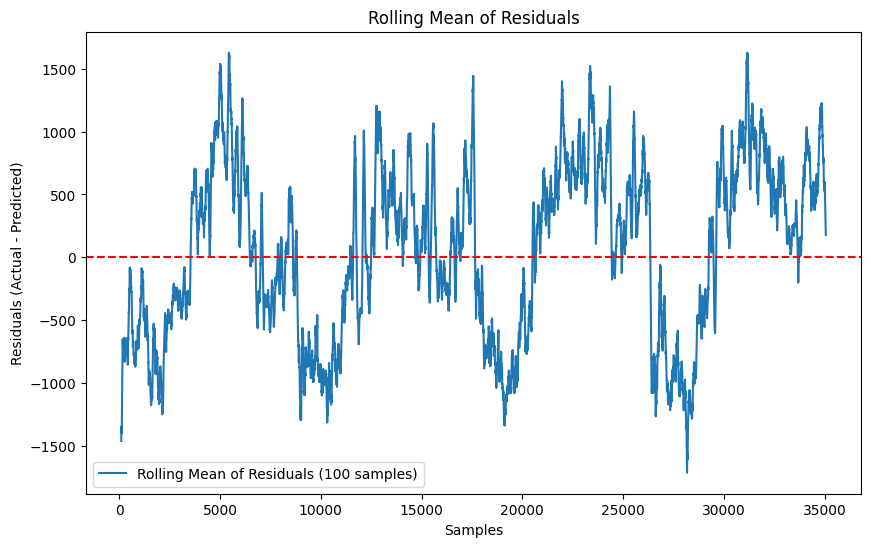

<Figure size 1000x600 with 0 Axes>

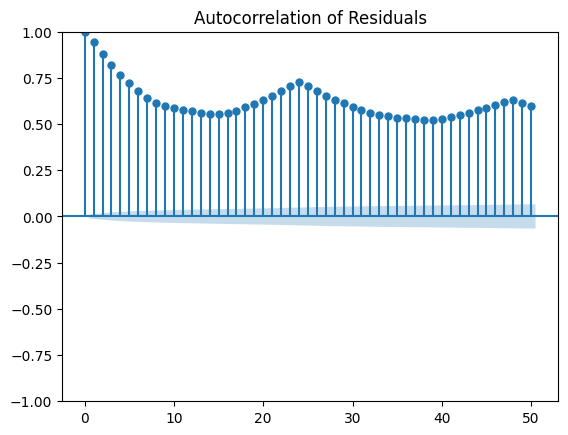

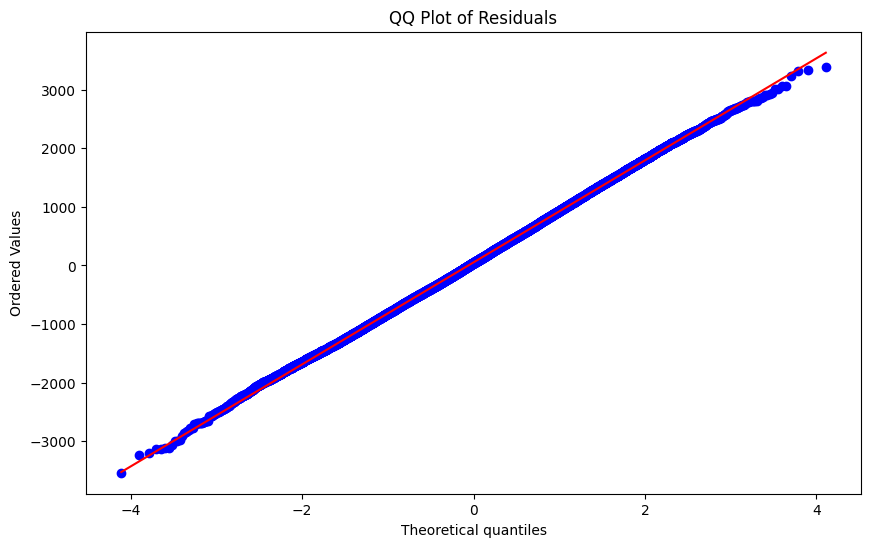

In [ ]:
# Plotting Functions for Reuse
def plot_results(y_true, predictions, history=None, residuals=None):
    # 6.1 Loss Curve
    if history is not None:
        plt.figure(figsize=(10,6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.legend()
        plt.show()

    # 6.2 Residual Plot
    residuals = y_true - predictions
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(residuals)), residuals, label='Residuals')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.show()

    # 6.3 Actual vs Predicted Scatter Plot
    plt.figure(figsize=(10,6))
    plt.scatter(y_true, predictions, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Perfect fit line
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    # 6.4 Error Distribution (Histogram)
    plt.figure(figsize=(10,6))
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.title('Residual Error Distribution')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.show()

    # 6.5 Prediction Error Over Time
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label='Prediction Error')
    plt.title('Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Prediction Error (Residuals)')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.6 Cumulative Prediction Error
    cumulative_error = np.cumsum(residuals)
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_error, label='Cumulative Error')
    plt.title('Cumulative Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Cumulative Error')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.7 Actual vs Predicted Over Time
    plt.figure(figsize=(10,6))
    plt.plot(y_true, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Actual vs Predicted Energy Consumption Over Time')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # 7.1 Rolling Mean of Residuals
    rolling_window = 100  # Adjust this window size
    rolling_mean_residual = pd.Series(residuals.flatten()).rolling(window=rolling_window).mean()
    plt.figure(figsize=(10,6))
    plt.plot(rolling_mean_residual, label=f'Rolling Mean of Residuals ({rolling_window} samples)')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Rolling Mean of Residuals')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.show()

    # 7.2 Autocorrelation of Residuals
    plt.figure(figsize=(10,6))
    sm.graphics.tsa.plot_acf(residuals.flatten(), lags=50)
    plt.title('Autocorrelation of Residuals')
    plt.show()

    # 7.3 QQ Plot of Residuals
    plt.figure(figsize=(10,6))
    stats.probplot(residuals.flatten(), dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')
    plt.show()

# Step 7: Generate all plots for the original evaluation
residuals = y_test_inv - test_predictions_inv
plot_results(y_test_inv, test_predictions_inv, history, residuals)

# Step 8: Generate all plots for the loaded model evaluation
residuals_loaded = y_test_inv - test_predictions_loaded_inv
plot_results(y_test_inv, test_predictions_loaded_inv, None, residuals_loaded)

## Initial hyper parameter tunning

In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras_tuner import RandomSearch
from keras.optimizers import Adam

# Step 1: Data Preparation
split_date = '2016-01-01'
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Step 2: Define and Build the MLP Model using Keras Tuner
def build_model(hp):
    model = Sequential()

    # First Dense layer
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))

    # Second Dense layer
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32),
                    activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    # Third Dense layer
    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=256, step=32),
                    activation='relu'))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.4, step=0.1)))

    # Dense output layer
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='mean_squared_error')

    return model

# Step 3: Initialize the Tuner (with reduced trials for computational resources)
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=2,  # Reduced number of trials for faster tuning
    executions_per_trial=1,  # Number of models to train for each trial
    directory='mlp_tuning',
    project_name='energy_consumption_forecasting'
)

# Step 4: Run the Hyperparameter Search (with reduced epochs)
tuner.search(X_train_scaled, y_train_scaled,
             epochs=50,  # Reduced epochs to save computational time
             validation_data=(X_test_scaled, y_test_scaled),
             #batch_size=64,  # Fixed batch size
             verbose=1)

# Step 5: Retrieve the Best Hyperparameters and Build the Best Model
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=50,  # Reduced epochs
                         batch_size=128,  # Fixed batch size
                         validation_data=(X_test_scaled, y_test_scaled),
                         verbose=1)

# Step 6: Save the model for future use
model_path = 'best_mlp_modelini.h5'
best_model.save(model_path)
print(f"Model saved to {model_path}")

# Step 7: Make Predictions and Evaluate the Model
train_predictions = best_model.predict(X_train_scaled)
test_predictions = best_model.predict(X_test_scaled)

# Inverse transform predictions and true values
train_predictions_inv = scaler_y.inverse_transform(train_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Evaluate the Model
rmse = mean_squared_error(y_test_inv, test_predictions_inv, squared=False)
mae = mean_absolute_error(y_test_inv, test_predictions_inv)
mape = mean_absolute_percentage_error(y_test_inv, test_predictions_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Step 8: Load the saved model for future use
def load_trained_model(model_path):
    model = load_model(model_path)
    print("Model loaded successfully.")
    return model

# Example of loading and using the saved model
loaded_model = load_trained_model('best_mlp_modelini.h5')

# Evaluate the loaded model with test data
loaded_test_predictions = loaded_model.predict(X_test_scaled)
loaded_test_predictions_inv = scaler_y.inverse_transform(loaded_test_predictions)

# Step 9: Evaluate the loaded model
rmse_loaded = mean_squared_error(y_test_inv, loaded_test_predictions_inv, squared=False)
mae_loaded = mean_absolute_error(y_test_inv, loaded_test_predictions_inv)
mape_loaded = mean_absolute_percentage_error(y_test_inv, loaded_test_predictions_inv)

print(f"Loaded Model RMSE: {rmse_loaded}")
print(f"Loaded Model MAE: {mae_loaded}")
print(f"Loaded Model MAPE: {mape_loaded}")



Trial 2 Complete [00h 07m 44s]
val_loss: 0.003816562006250024

Best val_loss So Far: 0.0017450524028390646
Total elapsed time: 00h 21m 34s
Best Hyperparameters: {'units_1': 256, 'dropout_1': 0.30000000000000004, 'units_2': 192, 'dropout_2': 0.4, 'units_3': 256, 'dropout_3': 0.4, 'learning_rate': 0.00027844320525596914}
Epoch 1/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0275 - val_loss: 0.0192
Epoch 2/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0067 - val_loss: 0.0093
Epoch 3/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0049 - val_loss: 0.0072
Epoch 4/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0041 - val_loss: 0.0056
Epoch 5/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 6/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 7/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 8/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0028 - va

Model saved to best_mlp_model.h5
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


RMSE: 832.5627577556636
MAE: 661.5945221087914
MAPE: 0.05703760633212179
Model loaded successfully.
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Loaded Model RMSE: 832.5627577556636
Loaded Model MAE: 661.5945221087914
Loaded Model MAPE: 0.05703760633212179


## Hyper parameter (BayesianOptimization)

Reloading Tuner from mlp_tuning_bayesian/energy_consumption_forecasting_bayesian/tuner0.json
Epoch 1/50


685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0460 - val_loss: 0.0124
Epoch 2/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 3/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0080 - val_loss: 0.0072
Epoch 4/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0062 - val_loss: 0.0071
Epoch 5/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 6/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 7/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0041 - val_loss: 0.0052
Epoch 8/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 9/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 10/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 11/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0031 - val_loss: 0.0035
Epoch 12/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.

Model saved to best_mlp_model.h5
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


RMSE: 733.8812621375704
MAE: 574.5821474285191
MAPE: 0.050271536357160175
Model loaded successfully.
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Loaded Model RMSE: 733.8812621375704
Loaded Model MAE: 574.5821474285191
Loaded Model MAPE: 0.050271536357160175


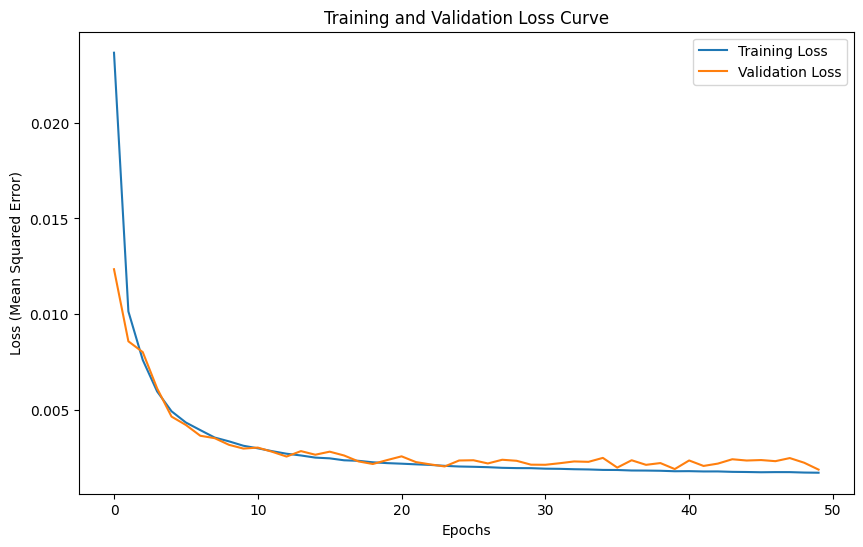

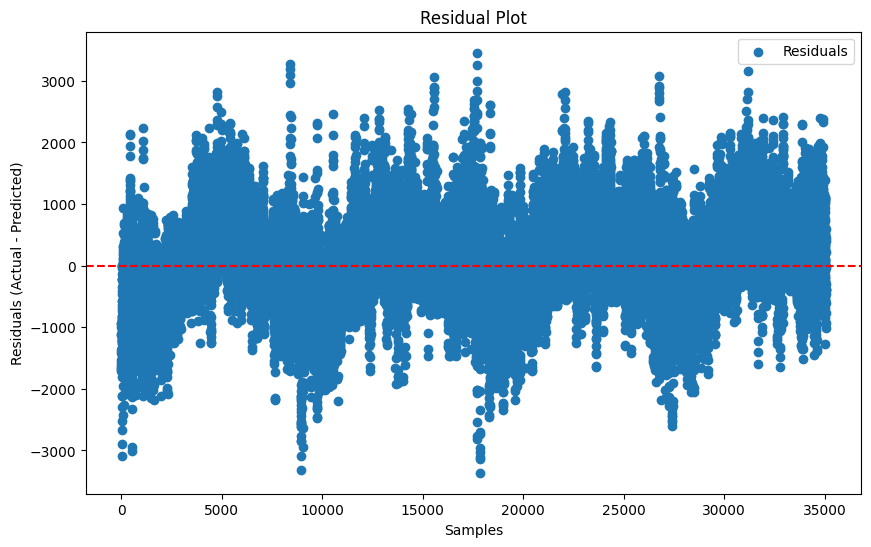

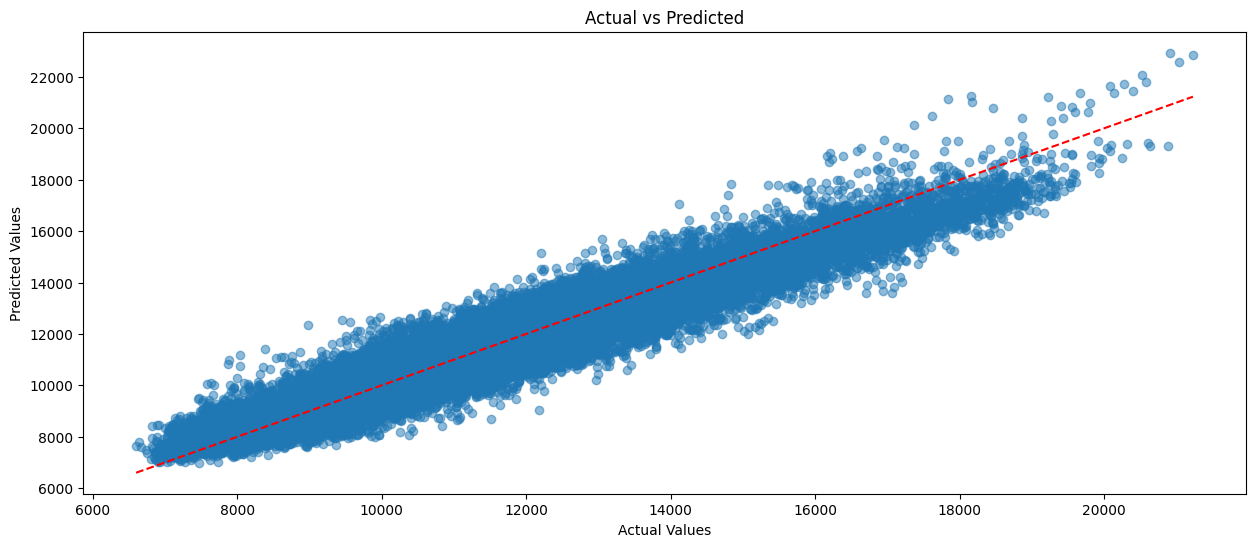

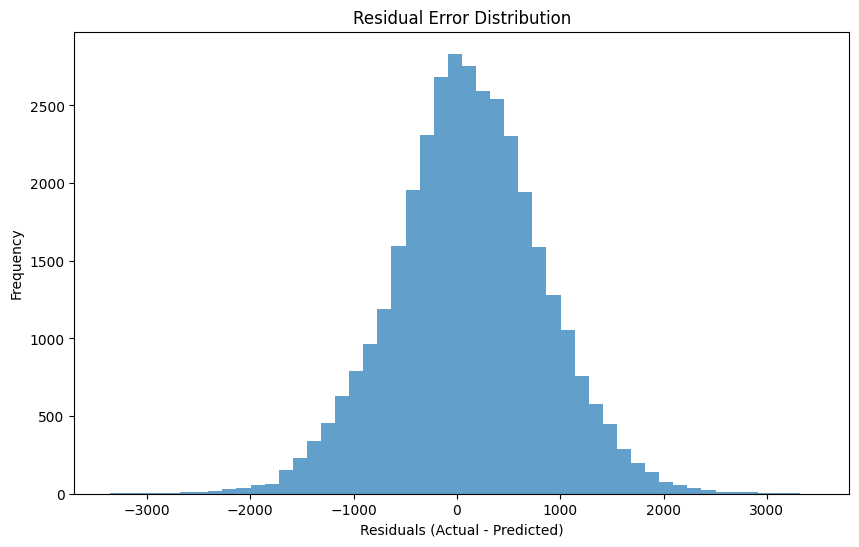

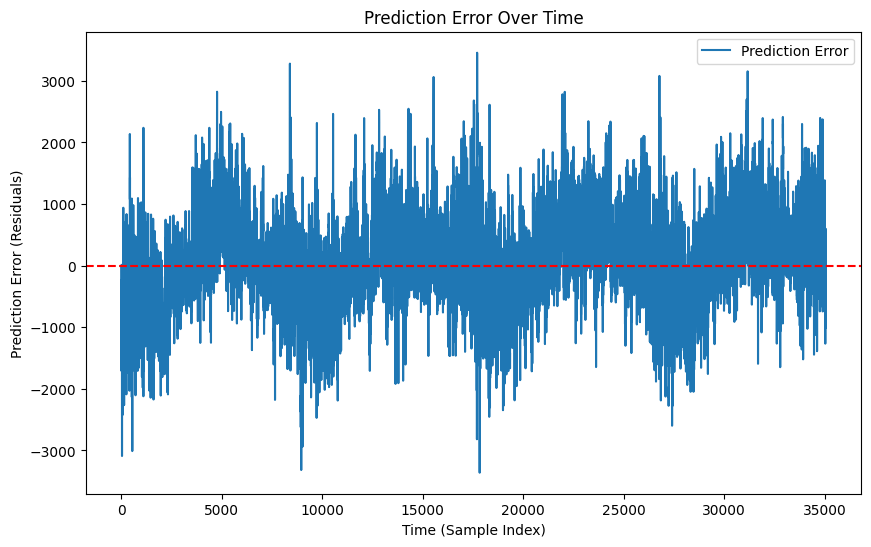

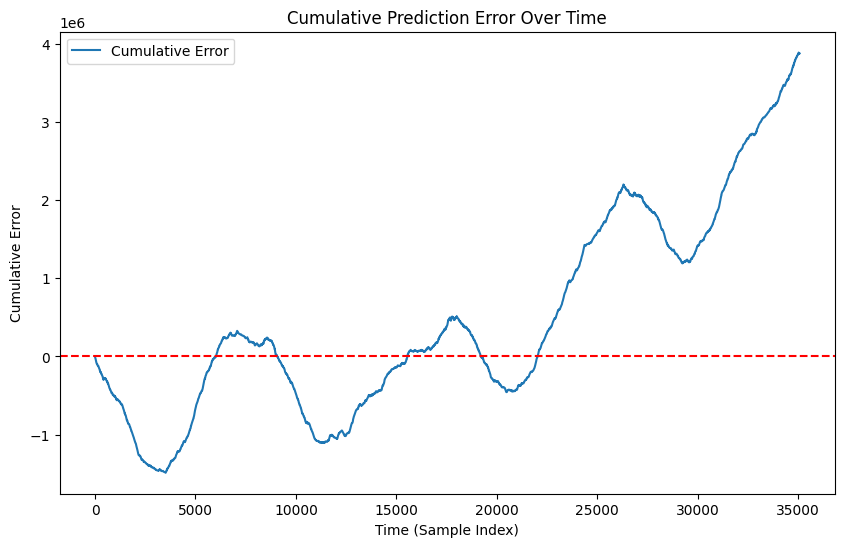

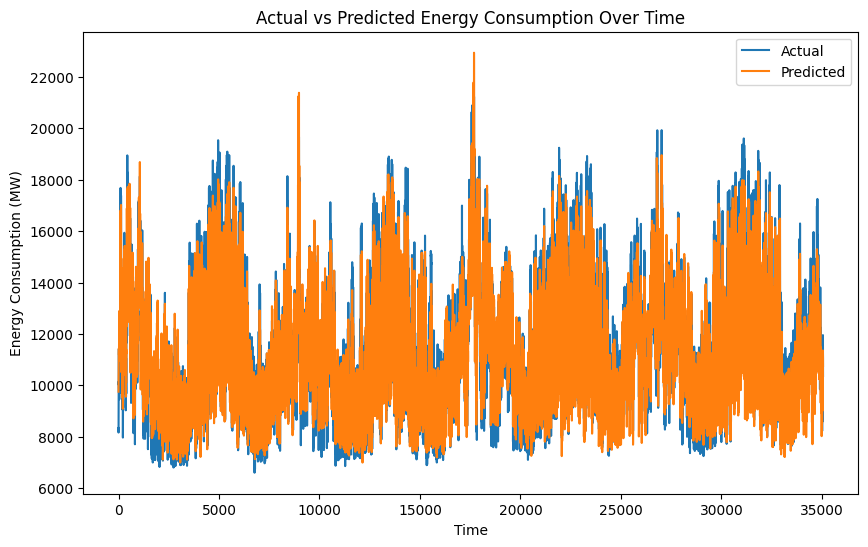

In [ ]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from keras.models import Sequential, load_model  # Import Sequential model and load_model for saving/loading
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from keras_tuner import BayesianOptimization  # For hyperparameter tuning



# Step 1: Define and Build the MLP Model using Keras Tuner (with narrow search space)
def build_model(hp):
    model = Sequential()

    # First Dense layer
    model.add(Dense(units=hp.Choice('units_1', values=[64, 128]),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(hp.Choice('dropout_1', values=[0.2, 0.3])))

    # Second Dense layer (fixed units and dropout)
    model.add(Dense(units=hp.Choice('units_2', values=[64, 128]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_2', values=[0.2, 0.3])))

    # Dense output layer
    model.add(Dense(units=1))

    # Compile model with narrower learning rate
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss='mean_squared_error')

    return model

# Step 2: Initialize the Tuner (Bayesian Optimization for efficiency)
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=2,  # Reduced trials for faster tuning
    executions_per_trial=1,
    directory='mlp_tuning_bayesian',
    project_name='energy_consumption_forecasting_bayesian'
)

# Step 3: Run the Hyperparameter Search (with reduced epochs)
tuner.search(X_train_scaled, y_train_scaled,
             epochs=50,  # Reduced epochs to save computational time
             validation_data=(X_test_scaled, y_test_scaled),
             batch_size=128,  # Fixed batch size
             verbose=1)

# Step 4: Retrieve and Build Best Model
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=50,  # Reduced epochs
                         batch_size=128,  # Fixed batch size
                         validation_data=(X_test_scaled, y_test_scaled),
                         verbose=1)

# Save and evaluate as in the previous code
# Step 5: Retrieve the Best Hyperparameters and Build the Best Model
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=50,  # Reduced epochs
                         batch_size=128,  # Fixed batch size
                         validation_data=(X_test_scaled, y_test_scaled),
                         verbose=1)

# Step 6: Save the model for future use
model_path = 'best_mlp_model.h5'
best_model.save(model_path)
print(f"Model saved to {model_path}")

# Step 7: Make Predictions and Evaluate the Model
train_predictions = best_model.predict(X_train_scaled)
test_predictions = best_model.predict(X_test_scaled)

# Inverse transform predictions and true values
train_predictions_inv = scaler_y.inverse_transform(train_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Evaluate the Model
rmse = mean_squared_error(y_test_inv, test_predictions_inv, squared=False)
mae = mean_absolute_error(y_test_inv, test_predictions_inv)
mape = mean_absolute_percentage_error(y_test_inv, test_predictions_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Step 8: Load the saved model for future use
def load_trained_model(model_path):
    model = load_model(model_path)
    print("Model loaded successfully.")
    return model

# Example of loading and using the saved model
loaded_model = load_trained_model('best_mlp_model.h5')

# Evaluate the loaded model with test data
loaded_test_predictions = loaded_model.predict(X_test_scaled)
loaded_test_predictions_inv = scaler_y.inverse_transform(loaded_test_predictions)

# Step 9: Evaluate the loaded model
rmse_loaded = mean_squared_error(y_test_inv, loaded_test_predictions_inv, squared=False)
mae_loaded = mean_absolute_error(y_test_inv, loaded_test_predictions_inv)
mape_loaded = mean_absolute_percentage_error(y_test_inv, loaded_test_predictions_inv)

print(f"Loaded Model RMSE: {rmse_loaded}")
print(f"Loaded Model MAE: {mae_loaded}")
print(f"Loaded Model MAPE: {mape_loaded}")

# Additional code for evaluation and plotting can be reused here

# 8.1 Loss Curve
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

# 8.2 Residual Plot
residuals = y_test_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(range(len(residuals)), residuals, label='Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Samples')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# 8.3 Actual vs Predicted Scatter Plot
plt.figure(figsize=(15,6))
plt.scatter(y_test_inv, test_predictions_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')  # Perfect fit line
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Additional diagnostic plots (same as your provided code):
# 8.4 Error Distribution (Histogram)
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Error Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# 8.5 Prediction Error Over Time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Prediction Error')
plt.title('Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Prediction Error (Residuals)')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.6 Cumulative Prediction Error
cumulative_error = np.cumsum(residuals)
plt.figure(figsize=(10,6))
plt.plot(cumulative_error, label='Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Cumulative Error')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.7 Actual vs Predicted Over Time
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

Reloading Tuner from mlp_tuning_bayesian/energy_consumption_forecasting_bayesian/tuner0.json
Epoch 1/150


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0370 - val_loss: 0.0124
Epoch 2/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172 - val_loss: 0.0125
Epoch 3/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0129 - val_loss: 0.0114
Epoch 4/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0110 - val_loss: 0.0105
Epoch 5/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 6/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 7/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 8/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 9/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 10/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 11/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 12/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0057 - val_

Model saved to best_mlp_model2.h5
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


RMSE: 789.7213645718205
MAE: 613.9988013633329
MAPE: 0.05226244896408752
Model loaded successfully.
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Loaded Model RMSE: 789.7213645718205
Loaded Model MAE: 613.9988013633329
Loaded Model MAPE: 0.05226244896408752


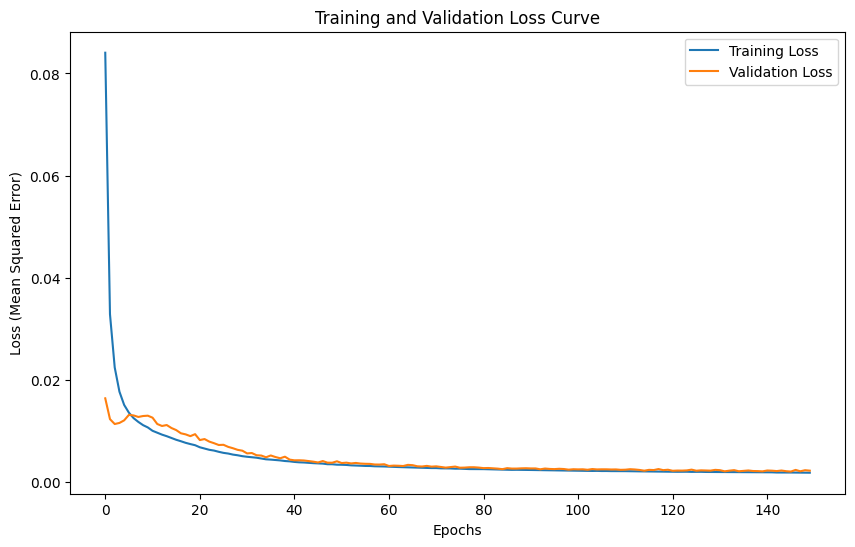

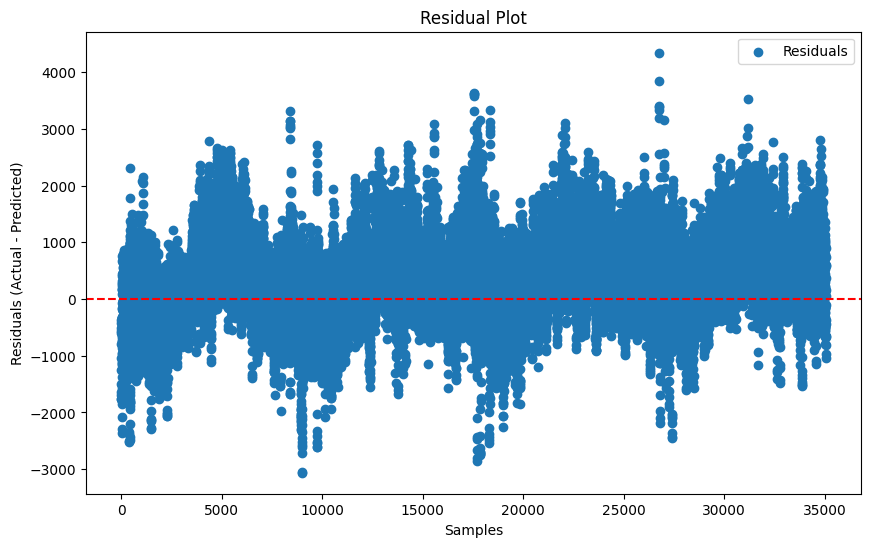

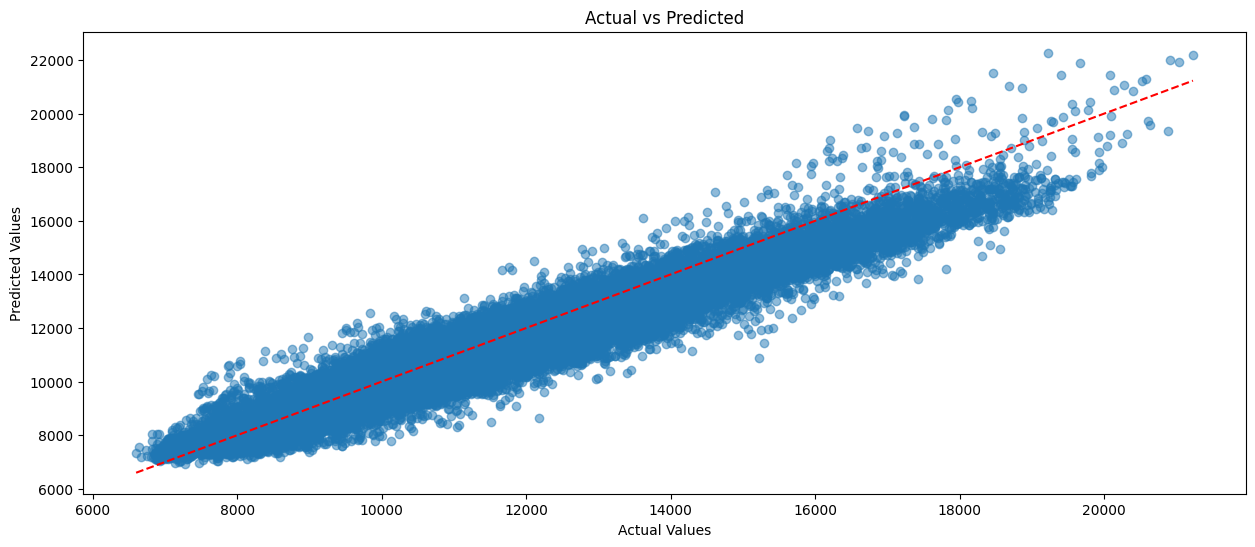

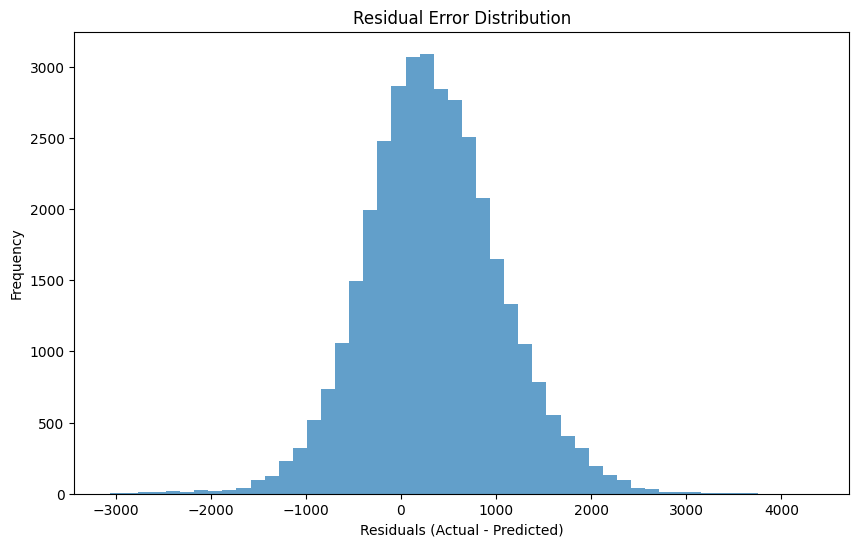

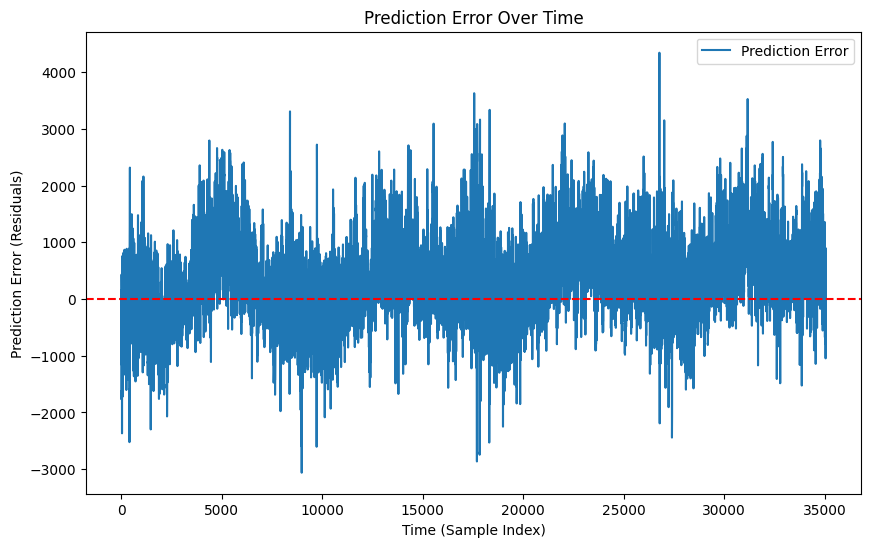

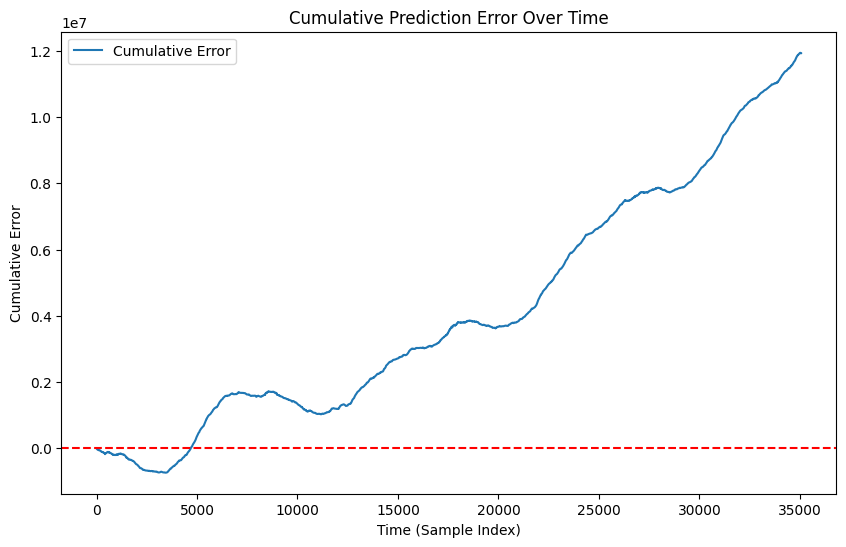

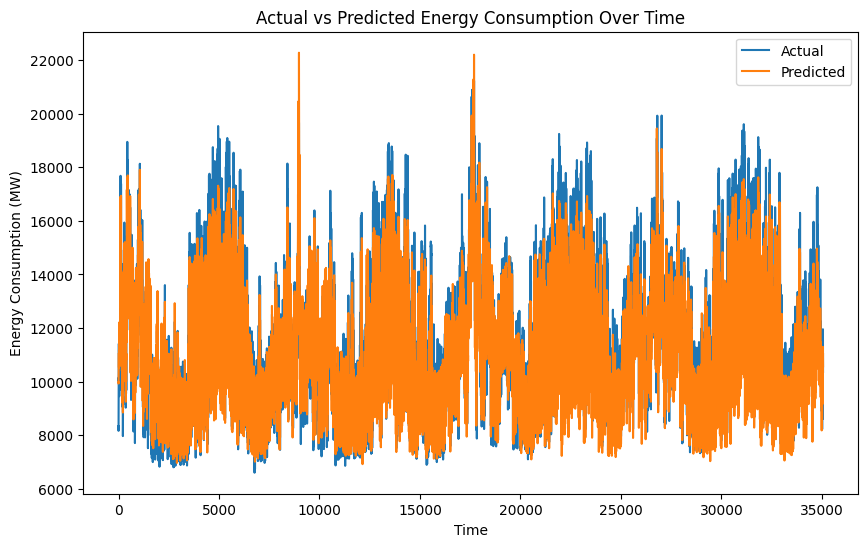

In [ ]:
# Required imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from keras.models import Sequential, load_model  # Import Sequential model and load_model for saving/loading
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from keras_tuner import BayesianOptimization  # For hyperparameter tuning

# Step 1: Define and Build the MLP Model using Keras Tuner (with narrow search space)
def build_model(hp):
    model = Sequential()

    # First Dense layer
    model.add(Dense(units=hp.Choice('units_1', values=[64, 128]),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    model.add(Dropout(hp.Choice('dropout_1', values=[0.2, 0.3])))

    # Second Dense layer (fixed units and dropout)
    model.add(Dense(units=hp.Choice('units_2', values=[64, 128]), activation='relu'))
    model.add(Dropout(hp.Choice('dropout_2', values=[0.2, 0.3])))

    # Dense output layer
    model.add(Dense(units=1))

    # Compile model with narrower learning rate
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss='mean_squared_error')

    return model

# Step 2: Initialize the Tuner (Bayesian Optimization for efficiency)
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=2,  # Reduced trials for faster tuning
    executions_per_trial=1,
    directory='mlp_tuning_bayesian',
    project_name='energy_consumption_forecasting_bayesian'
)

# Step 3: Run the Hyperparameter Search (with reduced epochs)
tuner.search(X_train_scaled, y_train_scaled,
             epochs=50,  # Reduced epochs to save computational time
             validation_data=(X_test_scaled, y_test_scaled),
             batch_size=128,  # Fixed batch size
             verbose=1)

# Step 4: Retrieve and Build Best Model
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=150,  # Reduced epochs
                         batch_size=1000,  # Fixed batch size
                         validation_data=(X_test_scaled, y_test_scaled),
                         verbose=1)

# Save and evaluate as in the previous code
# Step 5: Retrieve the Best Hyperparameters and Build the Best Model
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=150,  # Reduced epochs
                         batch_size=1000,  # Fixed batch size
                         validation_data=(X_test_scaled, y_test_scaled),
                         verbose=1)

# Step 6: Save the model for future use
model_path = 'best_mlp_model2.h5'
best_model.save(model_path)
print(f"Model saved to {model_path}")

# Step 7: Make Predictions and Evaluate the Model
train_predictions = best_model.predict(X_train_scaled)
test_predictions = best_model.predict(X_test_scaled)

# Inverse transform predictions and true values
train_predictions_inv = scaler_y.inverse_transform(train_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Evaluate the Model
rmse = mean_squared_error(y_test_inv, test_predictions_inv, squared=False)
mae = mean_absolute_error(y_test_inv, test_predictions_inv)
mape = mean_absolute_percentage_error(y_test_inv, test_predictions_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Step 8: Load the saved model for future use
def load_trained_model(model_path):
    model = load_model(model_path)
    print("Model loaded successfully.")
    return model

# Example of loading and using the saved model
loaded_model = load_trained_model('best_mlp_model2.h5')

# Evaluate the loaded model with test data
loaded_test_predictions = loaded_model.predict(X_test_scaled)
loaded_test_predictions_inv = scaler_y.inverse_transform(loaded_test_predictions)

# Step 9: Evaluate the loaded model
rmse_loaded = mean_squared_error(y_test_inv, loaded_test_predictions_inv, squared=False)
mae_loaded = mean_absolute_error(y_test_inv, loaded_test_predictions_inv)
mape_loaded = mean_absolute_percentage_error(y_test_inv, loaded_test_predictions_inv)

print(f"Loaded Model RMSE: {rmse_loaded}")
print(f"Loaded Model MAE: {mae_loaded}")
print(f"Loaded Model MAPE: {mape_loaded}")

# Additional code for evaluation and plotting can be reused here

# 8.1 Loss Curve
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

# 8.2 Residual Plot
residuals = y_test_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(range(len(residuals)), residuals, label='Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Samples')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# 8.3 Actual vs Predicted Scatter Plot
plt.figure(figsize=(15,6))
plt.scatter(y_test_inv, test_predictions_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')  # Perfect fit line
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Additional diagnostic plots (same as your provided code):
# 8.4 Error Distribution (Histogram)
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Error Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# 8.5 Prediction Error Over Time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Prediction Error')
plt.title('Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Prediction Error (Residuals)')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.6 Cumulative Prediction Error
cumulative_error = np.cumsum(residuals)
plt.figure(figsize=(10,6))
plt.plot(cumulative_error, label='Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Cumulative Error')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.7 Actual vs Predicted Over Time
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

# MODEL RESULT COLLECTION

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
import statsmodels.api as sm
import scipy.stats as stats

# Load your dataset (ensure 'datetime' and 'energy_consumption_mw' columns exist)
# Example: data_till_2019 = pd.read_csv('your_data.csv')

# Step 1: Data Preparation
split_date = '2016-01-01'
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


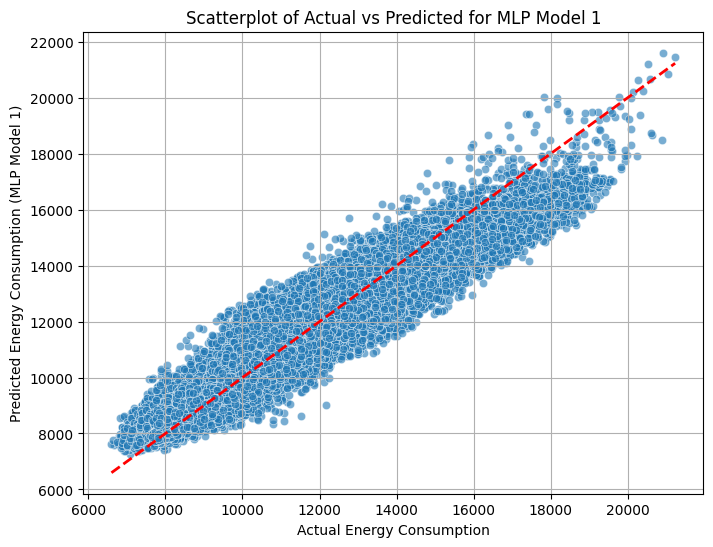

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


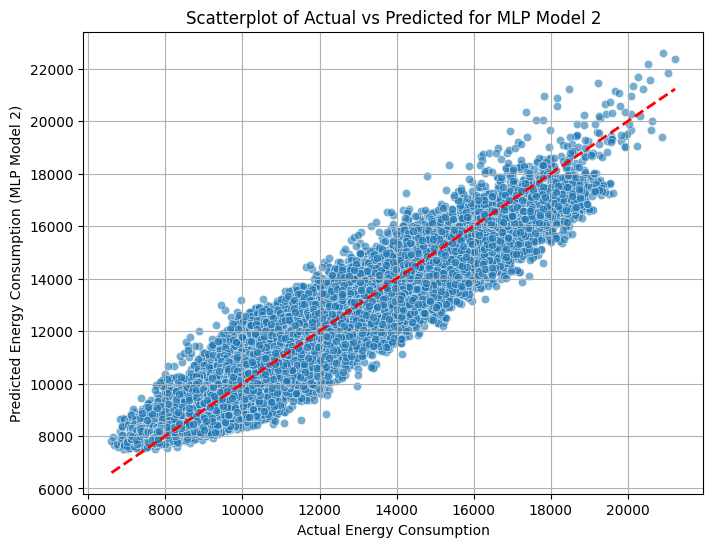

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


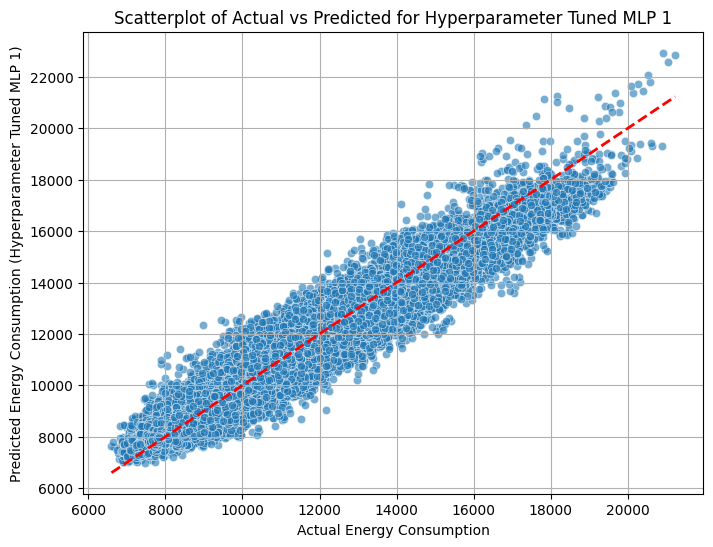

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


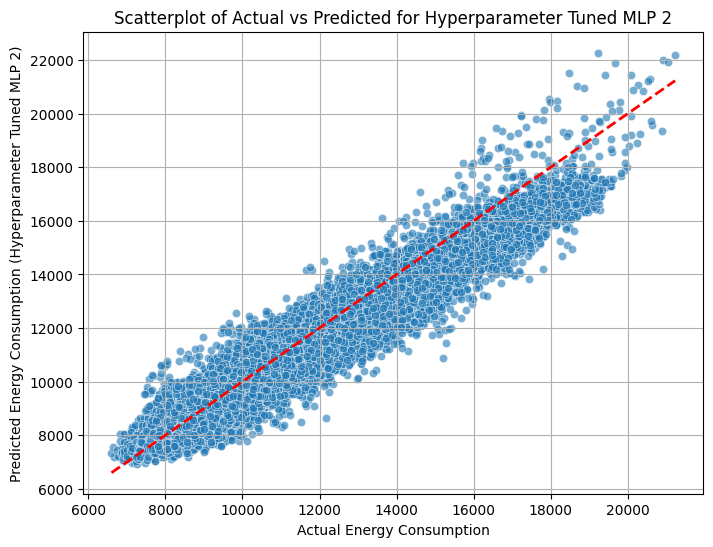

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


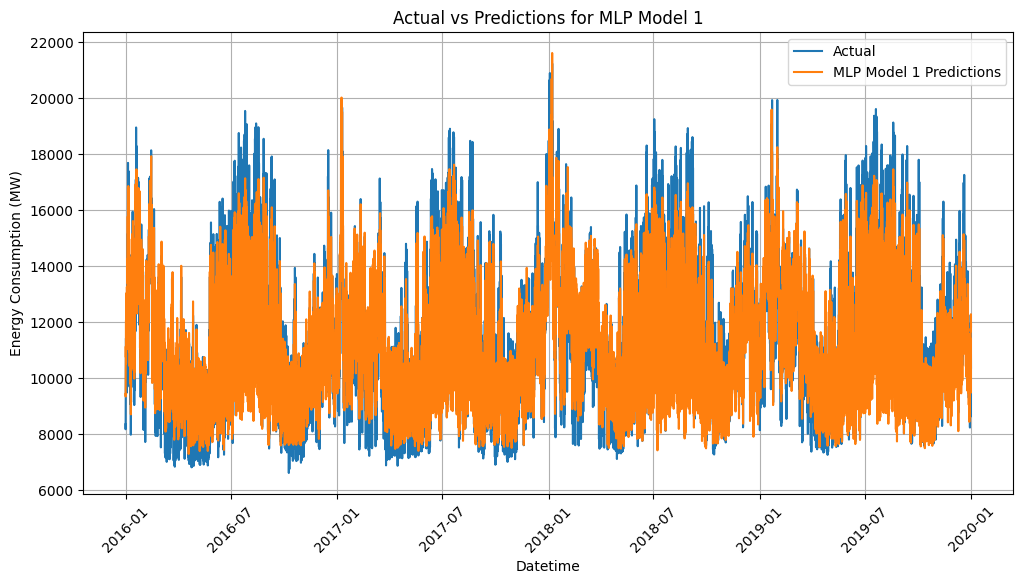

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


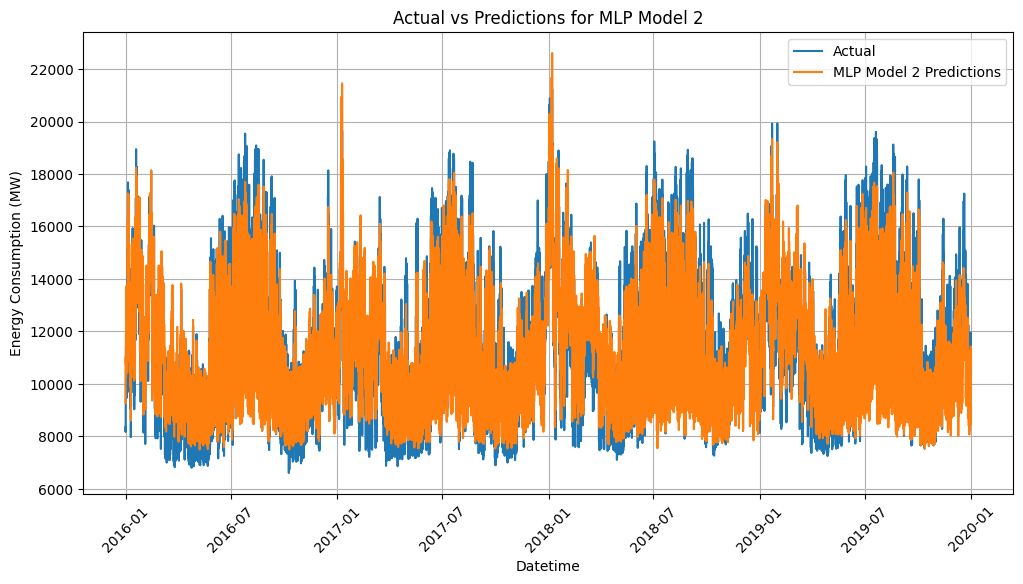

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


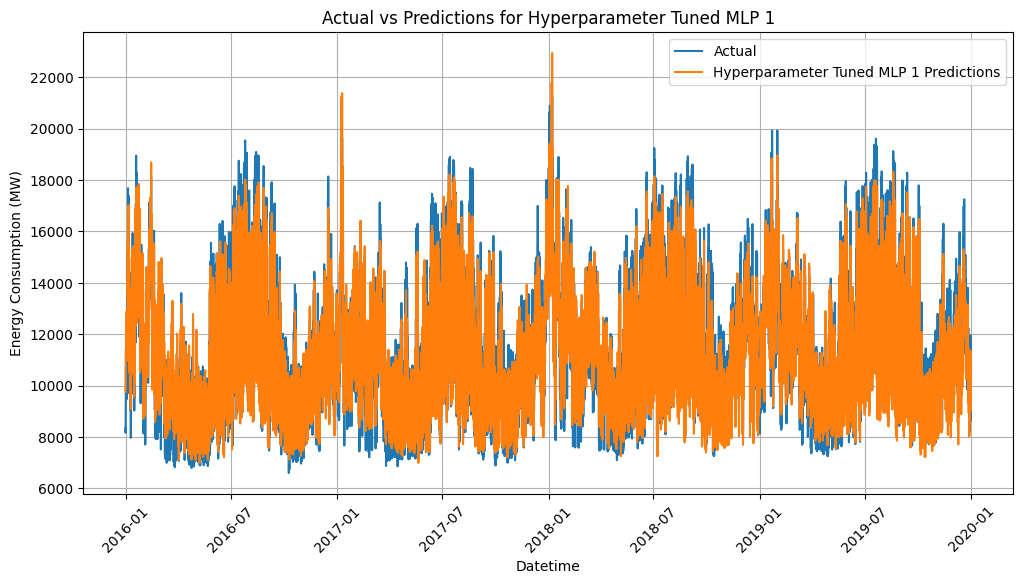

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


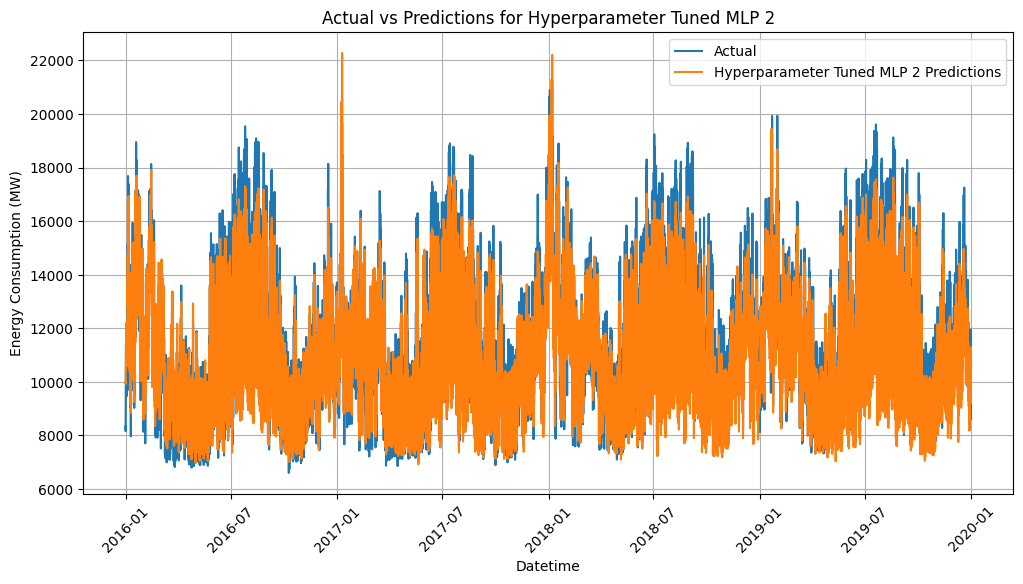

Feature importance doesn't apply to MLP models as they are neural networks.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import load_model
import seaborn as sns

# Load the MLP models
mlp_model1 = load_model('/content/mlp_energy_model1.h5')
mlp_model2 = load_model('/content/mlp_energy_model2.h5')
mlp_hp1 = load_model('/content/best_mlp_model.h5')
mlp_hp2 = load_model('/content/best_mlp_model2.h5')

# List of MLP models for iteration
mlp_models = [
    ('MLP Model 1', mlp_model1),
    ('MLP Model 2', mlp_model2),
    ('Hyperparameter Tuned MLP 1', mlp_hp1),
    ('Hyperparameter Tuned MLP 2', mlp_hp2)
]

# Ensure y_test is numeric and handle invalid values
y_test_numeric = pd.to_numeric(y_test, errors='coerce')  # Convert to numeric, set invalid values to NaN
y_test_numeric = y_test_numeric.dropna()  # Drop any NaN values

# Initialize an empty list to store evaluations
mlp_evaluations = []

# Create a DataFrame to store the actuals and predictions
results_df = test[['datetime', 'energy_consumption_mw']].copy()
results_df.columns = ['datetime', 'Actual']  # Rename for clarity

# Evaluate each MLP model
for model_name, model in mlp_models:
    predictions = model.predict(X_test_scaled)
    predictions_inv = scaler_y.inverse_transform(predictions).flatten()  # Flatten the predictions to 1D

    # Store predictions in the results DataFrame
    results_df[model_name + ' Predictions'] = predictions_inv

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_numeric, predictions_inv)
    mape = mean_absolute_percentage_error(y_test_numeric, predictions_inv) * 100
    rmse = mean_squared_error(y_test_numeric, predictions_inv, squared=False)
    r2 = r2_score(y_test_numeric, predictions_inv)

    mlp_evaluations.append([model_name, mape, mae, rmse, r2])

# Convert MLP evaluations to a DataFrame and export as CSV
mlp_evaluations_df = pd.DataFrame(mlp_evaluations, columns=['Model Name', 'MAPE', 'MAE', 'RMSE', 'R2'])
mlp_evaluations_df.to_csv('/content/mlp_model_evaluations.csv', index=False)

# Export the combined actual vs. predictions CSV for all MLP models
results_df.set_index('datetime', inplace=True)
results_df.to_csv('/content/actuals_vs_predictions_combined_mlp.csv')

# Plot scatter plot of True vs Predicted values for each MLP model
for model_name, model in mlp_models:
    predictions = model.predict(X_test_scaled)
    predictions_inv = scaler_y.inverse_transform(predictions).flatten()  # Flatten the predictions to 1D

    # Ensure both arrays are the same length
    min_len = min(len(y_test_numeric), len(predictions_inv))
    y_test_trimmed = y_test_numeric.iloc[:min_len]
    predictions_trimmed = predictions_inv[:min_len]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_trimmed, y=predictions_trimmed, alpha=0.6)

    # Plot a perfect prediction line (y = x)
    plt.plot([y_test_trimmed.min(), y_test_trimmed.max()],
             [y_test_trimmed.min(), y_test_trimmed.max()],
             color='red', lw=2, linestyle='--')

    plt.xlabel('Actual Energy Consumption')
    plt.ylabel(f'Predicted Energy Consumption ({model_name})')
    plt.title(f'Scatterplot of Actual vs Predicted for {model_name}')
    plt.grid(True)
    plt.show()

# Line plot of predictions vs actuals for each model separately
for model_name, model in mlp_models:
    predictions = model.predict(X_test_scaled)
    predictions_inv = scaler_y.inverse_transform(predictions).flatten()  # Flatten the predictions to 1D

    # Ensure both arrays are the same length
    min_len = min(len(test['datetime']), len(predictions_inv))

    plt.figure(figsize=(12, 6))
    plt.plot(test['datetime'][:min_len], y_test_numeric.iloc[:min_len], label='Actual')
    plt.plot(test['datetime'][:min_len], predictions_inv[:min_len], label=f'{model_name} Predictions')

    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.title(f'Actual vs Predictions for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Feature importance doesn't apply to MLP models directly, so this step will be skipped.
print("Feature importance doesn't apply to MLP models as they are neural networks.")
